### Dependicies and mounting the drive

In [ ]:
!pip install datasets torch torchvision matplotlib tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset

### VQ VAE 2

## Extract codebook vectors

### Subtask:
Use the VQ-VAE2 encoder to convert the training images into discrete codebook indices for both the top and bottom layers.

**Reasoning**:
Set the loaded VQ-VAE2 model to evaluation mode, iterate through the training data loader, and use the encoder to get the top and bottom codebook indices for each image.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

# import distributed as dist_fn # Commented out as it's not used and might cause issues


# Copyright 2018 The Sonnet Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Borrowed from https://github.com/deepmind/sonnet and ported it to PyTorch


class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            # Removed distributed training related code
            # dist_fn.all_reduce(embed_onehot_sum)
            # dist_fn.all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE2(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

## PART A

## Load the trained VQ-VAE2 model

### Subtask:
Load the state dictionary of the pre-trained VQ-VAE2 model to access its components, including the encoder and codebooks.

**Reasoning**:
Define the device, instantiate the VQVAE2 model with the correct parameters, load the pre-trained weights, and set the model to evaluation mode.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the emoji dataset
ds = load_dataset("valhalla/emoji-dataset", split="train")  # dataset is just one split

# Convert to pandas for splitting
import pandas as pd
df = pd.DataFrame(ds)

# Split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Helper: convert HuggingFace image object to PIL
def get_img(row):
    return row['image']  # Already PIL format

def get_text(row):
    return row['text']

# Example
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Train size: 2199
Val size: 275
Test size: 275


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class EmojiImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image

# Standard transforms (resize and normalize as rosinality expects, e.g., 256x256, [-1,1])
size=64
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_dataset = EmojiImageDataset(train_df, transform=transform)
val_dataset = EmojiImageDataset(val_df, transform=transform)
test_dataset = EmojiImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

def show_reconstructions(model, val_loader, device):
    model.eval()
    # Only unpack one value as the DataLoader yields only images
    imgs = next(iter(val_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recon, _ = model(imgs)

    # visualize
    n = min(8, imgs.size(0))
    orig = imgs[:n].cpu()
    recon = recon[:n].cpu()
    grid = torch.cat([orig, recon], dim=0)
    grid = vutils.make_grid(grid, nrow=n, normalize=True, scale_each=True)
    plt.figure(figsize=(12,6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("Top: Original | Bottom: Reconstructed")
    plt.axis('off')
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VQVAE2(in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=256,
        n_embed=512,
        decay=0.99,).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

def train_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, q_loss = model(batch)
        recon_loss = F.mse_loss(recon, batch)
        loss = recon_loss + q_loss  # as in rosinality repo
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Loop
num_epochs=201
for epoch in range(num_epochs):  # example
    train_loss = train_epoch(train_loader, model, optimizer)
    print(f"Epoch {epoch}: train loss {train_loss:.4f}")
    show_reconstructions(model, val_loader, device)


In [ ]:
import torch
import os

# Define the path to save the model in your Google Drive
model_save_path = '/content/drive/MyDrive/vqvae2_emoji_model.pth'
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/MyDrive/vqvae2_emoji_model.pth


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the saved model
model_load_path = '/content/drive/MyDrive/vqvae2_emoji_model.pth'
loaded_model = VQVAE2(in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=256,
        n_embed=512,
        decay=0.99,).to(device)
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

print(f"Model loaded successfully from {model_load_path}")

def evaluate_model(loader, model, device):
    model.eval()
    total_mse = 0
    total_mse_0_1 = 0 # To store MSE for images scaled to [0, 1]
    total_ssim = 0
    total_psnr = 0
    count = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon, _ = model(batch)

            # Calculate MSE on [-1, 1] range
            mse = F.mse_loss(recon, batch, reduction='sum').item()
            total_mse += mse

            # Calculate MSE on [0, 1] range for better interpretability
            batch_0_1 = (batch + 1) / 2.0
            recon_0_1 = (recon + 1) / 2.0
            mse_0_1 = F.mse_loss(recon_0_1, batch_0_1, reduction='sum').item()
            total_mse_0_1 += mse_0_1


            # Calculate SSIM and PSNR for each image in the batch
            for i in range(batch.size(0)):
                original_img = batch[i].permute(1, 2, 0).cpu().numpy()
                recon_img = recon[i].permute(1, 2, 0).cpu().numpy()

                # Convert to range [0, 1] for SSIM and PSNR calculation
                original_img_0_1 = (original_img - original_img.min()) / (original_img.max() - original_img.min())
                recon_img_0_1 = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min())


                total_ssim += ssim(original_img_0_1, recon_img_0_1, data_range=1.0, channel_axis=2)
                total_psnr += psnr(original_img_0_1, recon_img_0_1, data_range=1.0)

            count += batch.size(0)

    avg_mse = total_mse / count
    avg_mse_0_1 = total_mse_0_1 / count
    avg_mse_per_pixel = total_mse / (count * batch.shape[1] * batch.shape[2] * batch.shape[3])
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count

    return avg_mse, avg_mse_0_1, avg_mse_per_pixel, avg_ssim, avg_psnr

# Evaluate the model on the test set
avg_mse, avg_mse_0_1, avg_mse_per_pixel, avg_ssim, avg_psnr = evaluate_model(test_loader, loaded_model, device)

print(f"Test set metrics:")
print(f"  MSE per pixel: {avg_mse_per_pixel:.8f}")
print(f"  SSIM: {avg_ssim:.4f}")
print(f"  PSNR: {avg_psnr:.4f}")

Model loaded successfully from /content/drive/MyDrive/vqvae2_emoji_model.pth
Test set metrics:
  MSE per pixel: 0.00761348
  SSIM: 0.8972
  PSNR: 22.8269


### PixelSnail

## PART B

# Task
Train a PixelSnail prior on the discrete codes of a VQ-VAE2 model, then sample from the prior, decode the samples using the VQ-VAE2 decoder to generate novel emojis, and finally compare the generated emojis with the dataset emojis.

## Prepare data for pixelsnail

### Subtask:
Use the trained VQ-VAE2 encoder to get the discrete codes for the training dataset.


**Reasoning**:
Set the VQVAE2 model to evaluation mode and iterate through the training data loader to extract the top and bottom latent codes from the encoder output.



In [ ]:
loaded_model.eval()

top_codes = []
bottom_codes = []

with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        # The encode method returns quant_t, quant_b, diff, id_t, id_b
        quant_t, quant_b, diff, id_t, id_b = loaded_model.encode(batch)
        top_codes.append(id_t.cpu())
        bottom_codes.append(id_b.cpu())

top_codes = torch.cat(top_codes, dim=0)
bottom_codes = torch.cat(bottom_codes, dim=0)

print("Shape of top_codes:", top_codes.shape)
print("Shape of bottom_codes:", bottom_codes.shape)

Shape of top_codes: torch.Size([2199, 8, 8])
Shape of bottom_codes: torch.Size([2199, 16, 16])


## Train pixelsnail

### Subtask:
Train the PixelSnail model on the discrete codes obtained in the previous step.


**Reasoning**:
Instantiate the two PixelSNAIL models with appropriate parameters based on the shapes of the extracted codes and common practices for this architecture.



In [ ]:
# Copyright (c) Xi Chen
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

# Borrowed from https://github.com/neocxi/pixelsnail-public and ported it to PyTorch

from math import sqrt
from functools import partial, lru_cache

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


def wn_linear(in_dim, out_dim):
    return nn.utils.weight_norm(nn.Linear(in_dim, out_dim))


class WNConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
        activation=None,
    ):
        super().__init__()

        self.conv = nn.utils.weight_norm(
            nn.Conv2d(
                in_channel,
                out_channel,
                kernel_size,
                stride=stride,
                padding=padding,
                bias=bias,
            )
        )

        self.out_channel = out_channel

        if isinstance(kernel_size, int):
            kernel_size = [kernel_size, kernel_size]

        self.kernel_size = kernel_size

        self.activation = activation

    def forward(self, input):
        out = self.conv(input)

        if self.activation is not None:
            out = self.activation(out)

        return out


def shift_down(input, size=1):
    return F.pad(input, [0, 0, size, 0])[:, :, : input.shape[2], :]


def shift_right(input, size=1):
    return F.pad(input, [size, 0, 0, 0])[:, :, :, : input.shape[3]]


class CausalConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        stride=1,
        padding='downright',
        activation=None,
    ):
        super().__init__()

        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * 2

        self.kernel_size = kernel_size

        if padding == 'downright':
            pad = [kernel_size[1] - 1, 0, kernel_size[0] - 1, 0]

        elif padding == 'down' or padding == 'causal':
            pad = kernel_size[1] // 2

            pad = [pad, pad, kernel_size[0] - 1, 0]

        self.causal = 0
        if padding == 'causal':
            self.causal = kernel_size[1] // 2

        self.pad = nn.ZeroPad2d(pad)

        self.conv = WNConv2d(
            in_channel,
            out_channel,
            kernel_size,
            stride=stride,
            padding=0,
            activation=activation,
        )

    def forward(self, input):
        out = self.pad(input)

        if self.causal > 0:
            self.conv.conv.weight_v.data[:, :, -1, self.causal :].zero_()

        out = self.conv(out)

        return out


class GatedResBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        channel,
        kernel_size,
        conv='wnconv2d',
        activation=nn.ELU,
        dropout=0.1,
        auxiliary_channel=0,
        condition_dim=0,
    ):
        super().__init__()

        if conv == 'wnconv2d':
            conv_module = partial(WNConv2d, padding=kernel_size // 2)

        elif conv == 'causal_downright':
            conv_module = partial(CausalConv2d, padding='downright')

        elif conv == 'causal':
            conv_module = partial(CausalConv2d, padding='causal')

        self.activation = activation()
        self.conv1 = conv_module(in_channel, channel, kernel_size)

        if auxiliary_channel > 0:
            self.aux_conv = WNConv2d(auxiliary_channel, channel, 1)

        self.dropout = nn.Dropout(dropout)

        self.conv2 = conv_module(channel, in_channel * 2, kernel_size)

        if condition_dim > 0:
            # self.condition = nn.Linear(condition_dim, in_channel * 2, bias=False)
            self.condition = WNConv2d(condition_dim, in_channel * 2, 1, bias=False)

        self.gate = nn.GLU(1)

    def forward(self, input, aux_input=None, condition=None):
        out = self.conv1(self.activation(input))

        if aux_input is not None:
            out = out + self.aux_conv(self.activation(aux_input))

        out = self.activation(out)
        out = self.dropout(out)
        out = self.conv2(out)

        if condition is not None:
            condition = self.condition(condition)
            out += condition
            # out = out + condition.view(condition.shape[0], 1, 1, condition.shape[1])

        out = self.gate(out)
        out += input

        return out


@lru_cache(maxsize=64)
def causal_mask(size):
    shape = [size, size]
    mask = np.triu(np.ones(shape), k=1).astype(np.uint8).T
    start_mask = np.ones(size).astype(np.float32)
    start_mask[0] = 0

    return (
        torch.from_numpy(mask).unsqueeze(0),
        torch.from_numpy(start_mask).unsqueeze(1),
    )


class CausalAttention(nn.Module):
    def __init__(self, query_channel, key_channel, channel, n_head=8, dropout=0.1):
        super().__init__()

        self.query = wn_linear(query_channel, channel)
        self.key = wn_linear(key_channel, channel)
        self.value = wn_linear(key_channel, channel)

        self.dim_head = channel // n_head
        self.n_head = n_head

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key):
        batch, _, height, width = key.shape

        def reshape(input):
            return input.view(batch, -1, self.n_head, self.dim_head).transpose(1, 2)

        query_flat = query.view(batch, query.shape[1], -1).transpose(1, 2)
        key_flat = key.view(batch, key.shape[1], -1).transpose(1, 2)
        query = reshape(self.query(query_flat))
        key = reshape(self.key(key_flat)).transpose(2, 3)
        value = reshape(self.value(key_flat))

        attn = torch.matmul(query, key) / sqrt(self.dim_head)
        mask, start_mask = causal_mask(height * width)
        mask = mask.type_as(query)
        start_mask = start_mask.type_as(query)
        attn = attn.masked_fill(mask == 0, -1e4)
        attn = torch.softmax(attn, 3) * start_mask
        attn = self.dropout(attn)

        out = attn @ value
        out = out.transpose(1, 2).reshape(
            batch, height, width, self.dim_head * self.n_head
        )
        out = out.permute(0, 3, 1, 2)

        return out


class PixelBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        channel,
        kernel_size,
        n_res_block,
        attention=True,
        dropout=0.1,
        condition_dim=0,
    ):
        super().__init__()

        resblocks = []
        for i in range(n_res_block):
            resblocks.append(
                GatedResBlock(
                    in_channel,
                    channel,
                    kernel_size,
                    conv='causal',
                    dropout=dropout,
                    condition_dim=condition_dim,
                )
            )

        self.resblocks = nn.ModuleList(resblocks)

        self.attention = attention

        if attention:
            self.key_resblock = GatedResBlock(
                in_channel * 2 + 2, in_channel, 1, dropout=dropout
            )
            self.query_resblock = GatedResBlock(
                in_channel + 2, in_channel, 1, dropout=dropout
            )

            self.causal_attention = CausalAttention(
                in_channel + 2, in_channel * 2 + 2, in_channel // 2, dropout=dropout
            )

            self.out_resblock = GatedResBlock(
                in_channel,
                in_channel,
                1,
                auxiliary_channel=in_channel // 2,
                dropout=dropout,
            )

        else:
            self.out = WNConv2d(in_channel + 2, in_channel, 1)

    def forward(self, input, background, condition=None):
        out = input

        for resblock in self.resblocks:
            out = resblock(out, condition=condition)

        if self.attention:
            key_cat = torch.cat([input, out, background], 1)
            key = self.key_resblock(key_cat)
            query_cat = torch.cat([out, background], 1)
            query = self.query_resblock(query_cat)
            attn_out = self.causal_attention(query, key)
            out = self.out_resblock(out, attn_out)

        else:
            bg_cat = torch.cat([out, background], 1)
            out = self.out(bg_cat)

        return out


class CondResNet(nn.Module):
    def __init__(self, in_channel, channel, kernel_size, n_res_block):
        super().__init__()

        blocks = [WNConv2d(in_channel, channel, kernel_size, padding=kernel_size // 2)]

        for i in range(n_res_block):
            blocks.append(GatedResBlock(channel, channel, kernel_size))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class PixelSNAIL(nn.Module):
    def __init__(
        self,
        shape,
        n_class,
        channel,
        kernel_size,
        n_block,
        n_res_block,
        res_channel,
        attention=True,
        dropout=0.1,
        n_cond_res_block=0,
        cond_res_channel=0,
        cond_res_kernel=3,
        n_out_res_block=0,
    ):
        super().__init__()

        height, width = shape

        self.n_class = n_class

        if kernel_size % 2 == 0:
            kernel = kernel_size + 1

        else:
            kernel = kernel_size

        self.horizontal = CausalConv2d(
            n_class, channel, [kernel // 2, kernel], padding='down'
        )
        self.vertical = CausalConv2d(
            n_class, channel, [(kernel + 1) // 2, kernel // 2], padding='downright'
        )

        coord_x = (torch.arange(height).float() - height / 2) / height
        coord_x = coord_x.view(1, 1, height, 1).expand(1, 1, height, width)
        coord_y = (torch.arange(width).float() - width / 2) / width
        coord_y = coord_y.view(1, 1, 1, width).expand(1, 1, height, width)
        self.register_buffer('background', torch.cat([coord_x, coord_y], 1))

        self.blocks = nn.ModuleList()

        for i in range(n_block):
            self.blocks.append(
                PixelBlock(
                    channel,
                    res_channel,
                    kernel_size,
                    n_res_block,
                    attention=attention,
                    dropout=dropout,
                    condition_dim=cond_res_channel,
                )
            )

        if n_cond_res_block > 0:
            self.cond_resnet = CondResNet(
                n_class, cond_res_channel, cond_res_kernel, n_cond_res_block # Changed in_channel to n_class
            )

        out = []

        for i in range(n_out_res_block):
            out.append(GatedResBlock(channel, res_channel, 1))

        out.extend([nn.ELU(inplace=True), WNConv2d(channel, n_class, 1)])

        self.out = nn.Sequential(*out)

    def forward(self, input, condition=None, cache=None):
        if cache is None:
            cache = {}
        batch, height, width = input.shape
        input = (
            F.one_hot(input, self.n_class).permute(0, 3, 1, 2).type_as(self.background)
        )
        horizontal = shift_down(self.horizontal(input))
        vertical = shift_right(self.vertical(input))
        out = horizontal + vertical

        background = self.background[:, :, :height, :].expand(batch, 2, height, width)

        if condition is not None:
            if 'condition' in cache:
                condition = cache['condition']
                condition = condition[:, :, :height, :]

            else:
                condition = (
                    F.one_hot(condition, self.n_class)
                    .permute(0, 3, 1, 2)
                    .type_as(self.background)
                )
                condition = self.cond_resnet(condition)
                condition = F.interpolate(condition, size=(height, width), mode='nearest-exact') # Adjusted interpolation size
                cache['condition'] = condition.detach().clone()
                condition = condition[:, :, :height, :]


        for block in self.blocks:
            out = block(out, background, condition=condition)

        out = self.out(out)

        return out, cache

In [ ]:


# Instantiate VQVAE2 and load weights to get n_class
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vqvae_model = VQVAE2(in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=256,
        n_embed=512,
        decay=0.99,).to(device)
# Assuming the VQVAE2 model was saved to this path
vqvae_model_path = '/content/drive/MyDrive/vqvae2_emoji_model.pth'
vqvae_model.load_state_dict(torch.load(vqvae_model_path))
vqvae_model.eval() # Set to eval mode


# Determine dimensions
top_shape = top_codes.shape[1:]
bottom_shape = bottom_codes.shape[1:]
n_class = vqvae_model.quantize_t.n_embed # Assuming both quantize layers have the same number of embeds

# PixelSNAIL parameters (can be adjusted)
channel = 256
kernel_size = 5
n_block = 4
n_res_block = 2
res_channel = 128
attention = True
dropout = 0.1
n_cond_res_block = 3 # For bottom prior conditioning on top prior
cond_res_channel = 128
cond_res_kernel = 3
n_out_res_block = 0

In [ ]:

# Instantiate PixelSNAIL for top codes
top_prior = PixelSNAIL(
    shape=top_shape,
    n_class=n_class,
    channel=channel,
    kernel_size=kernel_size,
    n_block=n_block,
    n_res_block=n_res_block,
    res_channel=res_channel,
    attention=attention,
    dropout=dropout,
).to(device)

# Instantiate PixelSNAIL for bottom codes (conditioned on top codes)
bottom_prior = PixelSNAIL(
    shape=bottom_shape,
    n_class=n_class,
    channel=channel,
    kernel_size=kernel_size,
    n_block=n_block,
    n_res_block=n_res_block,
    res_channel=res_channel,
    attention=attention,
    dropout=dropout,
    n_cond_res_block=n_cond_res_block,
    cond_res_channel=cond_res_channel,
    cond_res_kernel=cond_res_kernel,
).to(device)

# Define optimizers
optimizer_top = torch.optim.Adam(top_prior.parameters(), lr=1e-4)
optimizer_bottom = torch.optim.Adam(bottom_prior.parameters(), lr=1e-4)

# Combine top and bottom codes into a dataset and dataloader for easier batching
from torch.utils.data import TensorDataset, DataLoader

prior_dataset = TensorDataset(top_codes, bottom_codes)
prior_loader = DataLoader(prior_dataset, batch_size=32, shuffle=True) # Using the same batch size as image loader

# Training loop
num_prior_epochs = 100 # Define number of epochs for prior training

for epoch in range(0, num_prior_epochs):
    total_top_loss = 0
    total_bottom_loss = 0

    for top_batch, bottom_batch in tqdm(prior_loader, desc=f"Epoch {epoch+1}/{num_prior_epochs}"):
        top_batch = top_batch.to(device)
        bottom_batch = bottom_batch.to(device)

        # Train top prior
        top_prior.train()
        optimizer_top.zero_grad()
        top_output, _ = top_prior(top_batch)
        top_loss = F.cross_entropy(top_output, top_batch)
        top_loss.backward()
        optimizer_top.step()
        total_top_loss += top_loss.item()

        # Train bottom prior
        bottom_prior.train()
        optimizer_bottom.zero_grad()
        # Condition bottom prior on top_batch
        bottom_output, _ = bottom_prior(bottom_batch, condition=top_batch)
        bottom_loss = F.cross_entropy(bottom_output, bottom_batch)
        bottom_loss.backward()
        optimizer_bottom.step()
        total_bottom_loss += bottom_loss.item()

    avg_top_loss = total_top_loss / len(prior_loader)
    avg_bottom_loss = total_bottom_loss / len(prior_loader)

    print(f"Epoch {epoch+1}/{num_prior_epochs}, Top Loss: {avg_top_loss:.4f}, Bottom Loss: {avg_bottom_loss:.4f}")

# Save the trained models
top_prior_save_path = '/content/drive/MyDrive/pixelsnail_top_prior.pth'
bottom_prior_save_path = '/content/drive/MyDrive/pixelsnail_bottom_prior.pth'

torch.save(top_prior.state_dict(), top_prior_save_path)
torch.save(bottom_prior.state_dict(), bottom_prior_save_path)

print(f"Top prior model saved to {top_prior_save_path}")
print(f"Bottom prior model saved to {bottom_prior_save_path}")

In [ ]:
# Load the trained PixelSNAIL models
top_prior_save_path = '/content/drive/MyDrive/pixelsnail_top_prior.pth'
bottom_prior_save_path = '/content/drive/MyDrive/pixelsnail_bottom_prior.pth'

# Ensure the models are on the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate PixelSNAIL for top codes and load state dict
top_prior = PixelSNAIL(
    shape=top_shape,
    n_class=n_class,
    channel=channel,
    kernel_size=kernel_size,
    n_block=n_block,
    n_res_block=n_res_block,
    res_channel=res_channel,
    attention=attention,
    dropout=dropout,
).to(device)
top_prior.load_state_dict(torch.load(top_prior_save_path, map_location=device))
top_prior.eval()

# Instantiate PixelSNAIL for bottom codes and load state dict
bottom_prior = PixelSNAIL(
    shape=bottom_shape,
    n_class=n_class,
    channel=channel,
    kernel_size=kernel_size,
    n_block=n_block,
    n_res_block=n_res_block,
    res_channel=res_channel,
    attention=attention,
    dropout=dropout,
    n_cond_res_block=n_cond_res_block,
    cond_res_channel=cond_res_channel,
    cond_res_kernel=cond_res_kernel,
).to(device)
bottom_prior.load_state_dict(torch.load(bottom_prior_save_path, map_location=device))
bottom_prior.eval()

print("PixelSNAIL models loaded successfully.")

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


PixelSNAIL models loaded successfully.


## Generate new codes

### Subtask:
Use the trained PixelSNAIL models to sample and generate new discrete codes for both the top and bottom layers.

**Reasoning**:
Set both PixelSNAIL prior models to evaluation mode. Then, implement sampling functions for both the top and bottom priors, generating codes pixel by pixel using the learned distributions and conditioning the bottom prior generation on the sampled top codes. Finally, call these sampling functions to generate a batch of new top and bottom codes.

In [ ]:
def sample_top_codes(model, shape, device):
    batch, height, width = shape
    sample = torch.zeros(shape, dtype=torch.long, device=device)
    cache = {}
    with torch.no_grad():
        for i in tqdm(range(height), desc="Sampling top codes"):
            for j in range(width):
                output, cache = model(sample[:, : i + 1, :], cache=cache)
                probs = F.softmax(output[:, :, i, j], dim=-1)
                sample[:, i, j] = torch.multinomial(probs, 1).squeeze(-1)
    return sample

def sample_bottom_codes(model, top_codes, shape, device):
    batch, height, width = shape
    sample = torch.zeros(shape, dtype=torch.long, device=device)
    cache = {}
    with torch.no_grad():
        for i in tqdm(range(height), desc="Sampling bottom codes"):
            for j in range(width):
                output, cache = model(sample[:, : i + 1, :], condition=top_codes, cache=cache)
                probs = F.softmax(output[:, :, i, j], dim=-1)
                sample[:, i, j] = torch.multinomial(probs, 1).squeeze(-1)
    return sample

# Define the number of samples to generate
num_samples = 64 # Can adjust this

# Generate new top and bottom codes
generated_top_codes = sample_top_codes(top_prior, (num_samples, *top_shape), device)
generated_bottom_codes = sample_bottom_codes(bottom_prior, generated_top_codes, (num_samples, *bottom_shape), device)

print("Shape of generated_top_codes:", generated_top_codes.shape)
print("Shape of generated_bottom_codes:", generated_bottom_codes.shape)

Sampling bottom codes: 100%|██████████| 16/16 [00:46<00:00,  2.92s/it]

Shape of generated_top_codes: torch.Size([64, 8, 8])
Shape of generated_bottom_codes: torch.Size([64, 16, 16])


## Decode generated codes

### Subtask:
Use the trained VQ-VAE2 decoder to convert the generated discrete codes back into images.

**Reasoning**:
Use the `decode_code` method of the loaded VQ-VAE2 model to convert the generated top and bottom codes into image tensors. Since the decoder outputs are in the range [-1, 1], denormalize them back to [0, 1] for visualization.

In [ ]:
# Decode the generated codes into images
loaded_model.eval()
with torch.no_grad():
    generated_images = loaded_model.decode_code(generated_top_codes, generated_bottom_codes)

# Denormalize the images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

print("Shape of generated_images:", generated_images.shape)

Shape of generated_images: torch.Size([64, 3, 64, 64])


## Compare generated and dataset emojis

### Subtask:
Visualize the generated emojis and compare them visually with examples from the original dataset.

**Reasoning**:
Use `torchvision.utils.make_grid` to create a grid of the generated images for easy visualization. Then, use `matplotlib.pyplot` to display the grid. For comparison, display a similar grid of original images from the validation set using the previously defined `show_reconstructions` function.

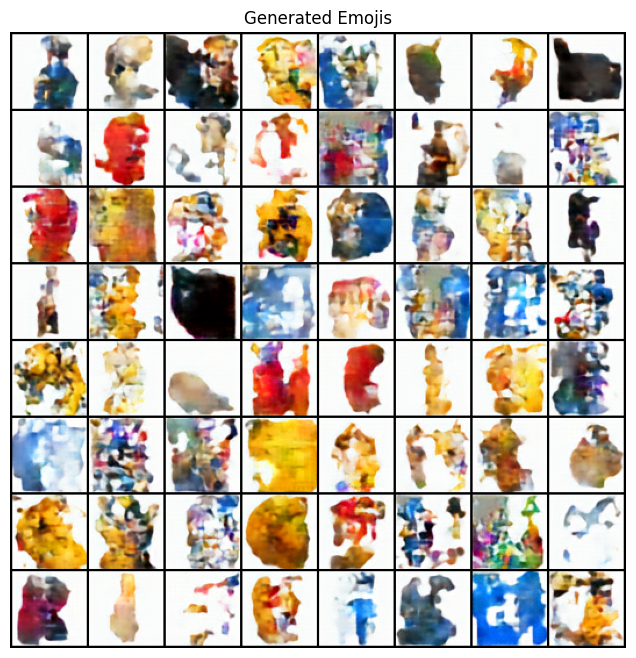


Original Emojis from Validation Set:


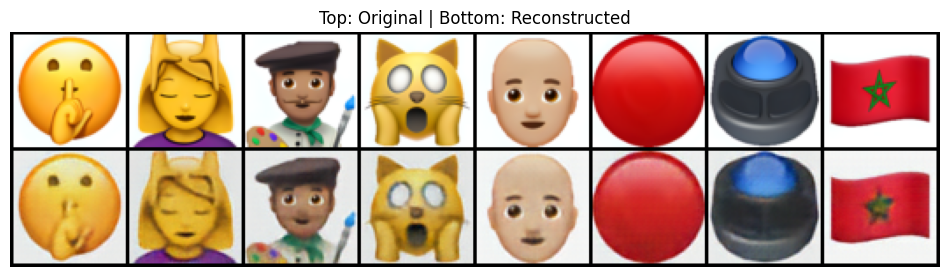

In [ ]:
# Visualize the generated images
grid = vutils.make_grid(generated_images, nrow=int(sqrt(num_samples)))
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.title("Generated Emojis")
plt.axis('off')
plt.show()

# Show some original images from the dataset for comparison
print("\nOriginal Emojis from Validation Set:")
show_reconstructions(loaded_model, test_loader, device)

**Reasoning**:
Run the training loop for a specified number of epochs to train the top and bottom PixelCNN priors on the extracted codebook entries.

In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.8 MB/s eta 0:00:00


## Prepare image data

### Subtask:
Convert the generated and original image tensors to the format expected by the FID metric (uint8 and on the correct device).

**Reasoning**:
Convert the generated and original image tensors to the format expected by the FID metric.

In [ ]:
import torchmetrics

# Move generated images to device
generated_images = generated_images.to(device)

# Scale and convert generated images to uint8 [0, 255]
generated_images_uint8 = (generated_images * 255).byte()

# Get all original images from the test_loader and concatenate them
# This assumes the entire test set can fit in memory
all_original_images = []
with torch.no_grad():
    for batch in test_loader:
        all_original_images.append(batch.to(device))

original_images_tensor = torch.cat(all_original_images, dim=0)

# Scale and convert original images from [-1, 1] to uint8 [0, 255]
original_images_uint8 = ((original_images_tensor + 1) / 2.0 * 255).byte()


print("Shape and dtype of generated_images_uint8:", generated_images_uint8.shape, generated_images_uint8.dtype)
print("Shape and dtype of original_images_uint8:", original_images_uint8.shape, original_images_uint8.dtype)

Shape and dtype of generated_images_uint8: torch.Size([64, 3, 64, 64]) torch.uint8
Shape and dtype of original_images_uint8: torch.Size([275, 3, 64, 64]) torch.uint8


## Initialize FID metric

### Subtask:
Initialize the `FrechetInceptionDistance` metric from `torchmetrics`.

**Reasoning**:
Initialize the FrechetInceptionDistance metric, specifying the feature extraction layer to use (e.g., 'inception').

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

# Initialize FID metric
# The feature parameter specifies the layer to use for feature extraction.
# 'inception' uses the output of the last pooling layer of InceptionV3.
fid_metric = FrechetInceptionDistance(feature=2048).to(device)

print("FID metric initialized.")

FID metric initialized.


## Update FID metric

### Subtask:
Iterate through the generated and original image datasets and update the FID metric with the respective images.

**Reasoning**:
Update the FID metric with batches of real and generated images.

In [ ]:
# Update FID metric with real images
fid_metric.update(original_images_uint8, real=True)

# Update FID metric with generated images
fid_metric.update(generated_images_uint8, real=False)

print("FID metric updated with real and generated images.")

FID metric updated with real and generated images.


## Compute FID score

### Subtask:
Compute the final FID score using the updated metric.

**Reasoning**:
Compute the FID score using the `compute` method of the FID metric.

In [ ]:
# Compute the FID score
fid_score = fid_metric.compute()

print(f"FID Score: {fid_score.item():.4f}")

FID Score: 340.9889


## Finish task

### Subtask:
Display the calculated FID score and summarize the process.

**Reasoning**:
Present the final FID score and a brief summary of the steps taken.

# Task
Train a PixelCNN model on the codebook entries generated by the VQ-VAE2 to generate new emojis.

## Define pixelcnn model

### Subtask:
Implement or import a PixelCNN model suitable for discrete image data (the codebook entries).

**Reasoning**:
Implement a PixelCNN model architecture suitable for discrete image data using masked convolutions. The model should be implemented as a PyTorch nn.Module and include support for conditioning.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding, condition_dim=0, *args, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, padding=padding, *args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', torch.zeros_like(self.weight.data))
        self.prepare_mask()

        if condition_dim > 0:
            # Using a 1x1 convolutional layer for conditioning
            self.condition_layer = nn.Conv2d(condition_dim, out_channels, kernel_size=1)
        else:
            self.condition_layer = None


    def prepare_mask(self):
        k_h, k_w = self.weight.size(-2), self.weight.size(-1)
        mid_h = k_h // 2
        mid_w = k_w // 2

        if self.mask_type == 'A':
            self.mask[:, :, :mid_h, :] = 1
            self.mask[:, :, mid_h, :mid_w] = 1
        elif self.mask_type == 'B':
            self.mask[:, :, :mid_h, :] = 1
            self.mask[:, :, mid_h, :mid_w + 1] = 1
        else:
            raise ValueError("Invalid mask type. Use 'A' or 'B'.")

    def forward(self, x, condition=None):
        self.weight.data *= self.mask
        out = super().forward(x)

        if self.condition_layer is not None and condition is not None:
            # Assuming condition is a tensor of shape (batch_size, condition_dim, H, W)
            conditioned_output = self.condition_layer(condition)
            out = out + conditioned_output

        return out

class PixelCNN(nn.Module):
    def __init__(self, in_channels, h_channels, n_layers, n_classes, condition_dim=0):
        super().__init__()
        self.n_classes = n_classes
        self.condition_dim = condition_dim

        self.initial_conv = MaskedConv2d('A', in_channels, h_channels, kernel_size=7, padding=3, condition_dim=condition_dim)

        self.layers = nn.ModuleList()
        for _ in range(n_layers):
            self.layers.append(nn.Sequential(
                MaskedConv2d('B', h_channels, h_channels, kernel_size=7, padding=3, condition_dim=condition_dim),
                nn.ReLU(True)
            ))

        self.output_conv = nn.Conv2d(h_channels, n_classes, kernel_size=1)

    def forward(self, x, condition=None):
        # One-hot encode the input
        x = F.one_hot(x, num_classes=self.n_classes).permute(0, 3, 1, 2).float()

        # If condition is provided, assume it's already spatially compatible (batch_size, condition_dim, H, W)
        # and pass it to the masked convolutional layers.
        # The MaskedConv2d layers handle the addition of conditioned output.

        x = self.initial_conv(x, condition=condition)
        x = F.relu(x)

        for layer in self.layers:
            # Pass condition to each masked convolutional layer
            x = layer[0](x, condition=condition) # Accessing the MaskedConv2d within Sequential
            x = layer[1](x) # Applying ReLU

        x = self.output_conv(x)
        return x

    def sample(self, shape, condition=None, device='cuda'):
        batch_size, height, width = shape
        sample = torch.zeros(shape, dtype=torch.long, device=device)

        if condition is not None:
             # Ensure condition is on the correct device
             condition = condition.to(device)
             # If condition is just codes, one-hot encode and spatially expand it for convolutional layers
             if condition.dim() == 3: # Assuming condition is (batch_size, H_cond, W_cond)
                 # Need to interpolate or resize the condition to match the spatial size of the sample
                 # For simplicity here, assuming condition spatial size is compatible or will be handled externally
                 # If condition is codes, one-hot encode and permute
                 condition = F.one_hot(condition, num_classes=self.n_classes).permute(0, 3, 1, 2).float()
                 # Interpolate condition to match the spatial size of the sample
                 condition = F.interpolate(condition, size=(height, width), mode='nearest-exact')
             elif condition.dim() == 4: # Assuming condition is already in image feature format (batch_size, C, H, W)
                 # Ensure condition spatial size matches sample spatial size if needed
                 condition = F.interpolate(condition, size=(height, width), mode='nearest-exact')


        with torch.no_grad():
            for i in tqdm(range(height), desc="Sampling"):
                for j in range(width):
                    # Create a temporary input with the sampled pixels so far
                    # For the current pixel (i, j), the input should only include pixels above and to the left
                    # The MaskedConv2d handles the masking internally, so we just need the current state of the sample
                    input_sample = sample[:, : i + 1, :]
                    if i == height - 1:
                         input_sample = sample[:, i:i+1, :j+1]


                    # Prepare input for the model - need to pad the input_sample to the full shape for the model forward pass
                    padded_input_sample = torch.zeros(shape, dtype=torch.long, device=device)
                    padded_input_sample[:, :i+1, :] = sample[:, :i+1, :]
                    padded_input_sample[:, i, :j+1] = sample[:, i, :j+1]


                    # Get the model output for the current pixel
                    # The model's forward pass expects the full shape for correct masking
                    # We only care about the output logits for the pixel at (i, j)
                    model_output = self(padded_input_sample, condition=condition)
                    logits = model_output[:, :, i, j]

                    # Sample the next pixel based on the probability distribution
                    probs = F.softmax(logits, dim=-1)
                    sample[:, i, j] = torch.multinomial(probs, 1).squeeze(-1)

        return sample

## Prepare data for pixelcnn

### Subtask:
Ensure the extracted top and bottom codes are in the correct format for training the PixelCNN model.

**Reasoning**:
Combine the top and bottom codes into a single PyTorch Dataset and create a DataLoader for training the PixelCNN models.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Combine top and bottom codes into a dataset
prior_dataset = TensorDataset(top_codes, bottom_codes)

# Create a DataLoader for the dataset
# Using the same batch size as the image loader for consistency
batch_size = 32
prior_loader = DataLoader(prior_dataset, batch_size=batch_size, shuffle=True)

print(f"Prior dataset created with {len(prior_dataset)} samples.")
print(f"Prior dataloader created with batch size {batch_size}.")

Prior dataset created with 2199 samples.
Prior dataloader created with batch size 32.


## Define training loop

### Subtask:
Set up the training function for the PixelCNN, including the optimizer and loss function (likely cross-entropy since the output is a probability distribution over the codebook entries).

**Reasoning**:
Set up the training function for the PixelCNN, including the optimizer and loss function.

In [ ]:
def train_epoch_pixelcnn(loader, top_model, bottom_model, optimizer_top, optimizer_bottom, device):
    top_model.train()
    bottom_model.train()
    total_top_loss = 0
    total_bottom_loss = 0

    for top_batch, bottom_batch in tqdm(loader, desc="Training PixelCNN"):
        top_batch = top_batch.to(device)
        bottom_batch = bottom_batch.to(device)

        # Train top prior (PixelCNN)
        optimizer_top.zero_grad()
        top_output = top_model(top_batch)
        # Permute the output to have the class dimension before spatial dimensions for F.cross_entropy
        top_loss = F.cross_entropy(top_output, top_batch)
        top_loss.backward()
        optimizer_top.step()
        total_top_loss += top_loss.item()

        # Train bottom prior (PixelCNN conditioned on top codes)
        optimizer_bottom.zero_grad()
        # For the bottom PixelCNN, the input is the bottom codes, and the condition is the top codes
        # Need to pass the one-hot encoded and spatially expanded top codes as condition
        # The PixelCNN model's forward handles the one-hot encoding and spatial expansion of the input (bottom_batch)
        # We need to one-hot encode and spatially expand the top_batch for the condition input as well
        # The PixelCNN forward expects condition to be (batch_size, condition_dim, H, W)
        # Here, condition_dim is n_class, and H, W should match the spatial size of the bottom codes
        top_batch_one_hot = F.one_hot(top_batch, num_classes=top_model.n_classes).permute(0, 3, 1, 2).float()
        # Interpolate top_batch_one_hot to match the spatial size of bottom_batch
        condition_for_bottom = F.interpolate(top_batch_one_hot, size=bottom_batch.shape[1:], mode='nearest-exact')

        bottom_output = bottom_model(bottom_batch, condition=condition_for_bottom)
        # Permute the output for F.cross_entropy
        bottom_loss = F.cross_entropy(bottom_output, bottom_batch)
        bottom_loss.backward()
        optimizer_bottom.step()
        total_bottom_loss += bottom_loss.item()

    avg_top_loss = total_top_loss / len(loader)
    avg_bottom_loss = total_bottom_loss / len(loader)

    return avg_top_loss, avg_bottom_loss

# Instantiate PixelCNN for top codes
# Parameters for PixelCNN (can be adjusted)
in_channels_pixelcnn = n_class # Input is the one-hot encoded codebook entries
h_channels_pixelcnn = 256 # Hidden channels
n_layers_pixelcnn = 25 # Number of layers

top_prior_pixelcnn = PixelCNN(
    in_channels=in_channels_pixelcnn,
    h_channels=h_channels_pixelcnn,
    n_layers=n_layers_pixelcnn,
    n_classes=n_class # Output is a distribution over the codebook entries
).to(device)

# Instantiate PixelCNN for bottom codes (conditioned on top codes)
# For the bottom PixelCNN, the input is the bottom codes, and it will be conditioned on the top codes.
# The condition_dim for the bottom PixelCNN will be the number of classes (n_class)
bottom_prior_pixelcnn = PixelCNN(
    in_channels=in_channels_pixelcnn,
    h_channels=h_channels_pixelcnn,
    n_layers=n_layers_pixelcnn,
    n_classes=n_class, # Output is a distribution over the codebook entries
    condition_dim=n_class # Conditioning on the one-hot encoded top codes
).to(device)


# Define optimizers
optimizer_top = torch.optim.Adam(top_prior_pixelcnn.parameters(), lr=2e-5)
optimizer_bottom = torch.optim.Adam(bottom_prior_pixelcnn.parameters(), lr=2e-5)

## Train PixelCNN

### Subtask:
Train the PixelCNN model on the prepared codebook entries.

**Reasoning**:
Run the training loop for a specified number of epochs to train the top and bottom PixelCNN priors on the extracted codebook entries.

In [ ]:
# Training loop
num_pixelcnn_epochs = 100 # Define number of epochs for PixelCNN training (can adjust)

for epoch in range(num_pixelcnn_epochs):
    avg_top_loss, avg_bottom_loss = train_epoch_pixelcnn(
        prior_loader,
        top_prior_pixelcnn,
        bottom_prior_pixelcnn,
        optimizer_top,
        optimizer_bottom,
        device
    )
    if(epoch%10 == 0 and epoch!=0):
      top_pixelcnn_save_path = '/content/drive/MyDrive/pixelcnn_top_prior.pth'
      bottom_pixelcnn_save_path = '/content/drive/MyDrive/pixelcnn_bottom_prior.pth'

      torch.save(top_prior_pixelcnn.state_dict(), top_pixelcnn_save_path)
      torch.save(bottom_prior_pixelcnn.state_dict(), bottom_pixelcnn_save_path)

      print(f"Top PixelCNN model saved to {top_pixelcnn_save_path}")
      print(f"Bottom PixelCNN model saved to {bottom_pixelcnn_save_path}")
    print(f"Epoch {epoch+1}/{num_pixelcnn_epochs}, Top PixelCNN Loss: {avg_top_loss:.4f}, Bottom PixelCNN Loss: {avg_bottom_loss:.4f}")

# Save the trained PixelCNN models
top_pixelcnn_save_path = '/content/drive/MyDrive/pixelcnn_top_prior.pth'
bottom_pixelcnn_save_path = '/content/drive/MyDrive/pixelcnn_bottom_prior.pth'

torch.save(top_prior_pixelcnn.state_dict(), top_pixelcnn_save_path)
torch.save(bottom_prior_pixelcnn.state_dict(), bottom_pixelcnn_save_path)

print(f"Top PixelCNN model saved to {top_pixelcnn_save_path}")
print(f"Bottom PixelCNN model saved to {bottom_pixelcnn_save_path}")

Training PixelCNN: 100%|██████████| 69/69 [01:56<00:00,  1.68s/it]


Epoch 1/100, Top PixelCNN Loss: 6.1544, Bottom PixelCNN Loss: 5.8668


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 2/100, Top PixelCNN Loss: 5.6386, Bottom PixelCNN Loss: 5.2213


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 3/100, Top PixelCNN Loss: 5.1950, Bottom PixelCNN Loss: 4.7079


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 4/100, Top PixelCNN Loss: 4.9448, Bottom PixelCNN Loss: 4.4457


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 5/100, Top PixelCNN Loss: 4.8050, Bottom PixelCNN Loss: 4.3206


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 6/100, Top PixelCNN Loss: 4.7315, Bottom PixelCNN Loss: 4.2439


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 7/100, Top PixelCNN Loss: 4.6883, Bottom PixelCNN Loss: 4.1869


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 8/100, Top PixelCNN Loss: 4.6584, Bottom PixelCNN Loss: 4.1422


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 9/100, Top PixelCNN Loss: 4.6350, Bottom PixelCNN Loss: 4.0980


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 10/100, Top PixelCNN Loss: 4.6092, Bottom PixelCNN Loss: 4.0635


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 11/100, Top PixelCNN Loss: 4.5884, Bottom PixelCNN Loss: 4.0396


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 12/100, Top PixelCNN Loss: 4.5687, Bottom PixelCNN Loss: 4.0086


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 13/100, Top PixelCNN Loss: 4.5529, Bottom PixelCNN Loss: 3.9861


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 14/100, Top PixelCNN Loss: 4.5412, Bottom PixelCNN Loss: 3.9668


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 15/100, Top PixelCNN Loss: 4.5372, Bottom PixelCNN Loss: 3.9456


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 16/100, Top PixelCNN Loss: 4.5310, Bottom PixelCNN Loss: 3.9259


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 17/100, Top PixelCNN Loss: 4.5259, Bottom PixelCNN Loss: 3.9084


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 18/100, Top PixelCNN Loss: 4.5231, Bottom PixelCNN Loss: 3.8943


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 19/100, Top PixelCNN Loss: 4.5186, Bottom PixelCNN Loss: 3.8779


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 20/100, Top PixelCNN Loss: 4.5170, Bottom PixelCNN Loss: 3.8595


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 21/100, Top PixelCNN Loss: 4.5158, Bottom PixelCNN Loss: 3.8466


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 22/100, Top PixelCNN Loss: 4.5119, Bottom PixelCNN Loss: 3.8260


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 23/100, Top PixelCNN Loss: 4.5102, Bottom PixelCNN Loss: 3.8141


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 24/100, Top PixelCNN Loss: 4.5089, Bottom PixelCNN Loss: 3.8036


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 25/100, Top PixelCNN Loss: 4.5049, Bottom PixelCNN Loss: 3.7852


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 26/100, Top PixelCNN Loss: 4.5054, Bottom PixelCNN Loss: 3.7737


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 27/100, Top PixelCNN Loss: 4.5034, Bottom PixelCNN Loss: 3.7655


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]


Epoch 28/100, Top PixelCNN Loss: 4.4996, Bottom PixelCNN Loss: 3.7494


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 29/100, Top PixelCNN Loss: 4.5004, Bottom PixelCNN Loss: 3.7413


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 30/100, Top PixelCNN Loss: 4.4974, Bottom PixelCNN Loss: 3.7319


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 31/100, Top PixelCNN Loss: 4.4950, Bottom PixelCNN Loss: 3.7182


Training PixelCNN: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]


Epoch 32/100, Top PixelCNN Loss: 4.4939, Bottom PixelCNN Loss: 3.7088


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 33/100, Top PixelCNN Loss: 4.4919, Bottom PixelCNN Loss: 3.6956


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 34/100, Top PixelCNN Loss: 4.4840, Bottom PixelCNN Loss: 3.6865


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 35/100, Top PixelCNN Loss: 4.4682, Bottom PixelCNN Loss: 3.6783


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 36/100, Top PixelCNN Loss: 4.4523, Bottom PixelCNN Loss: 3.6697


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 37/100, Top PixelCNN Loss: 4.4363, Bottom PixelCNN Loss: 3.6604


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 38/100, Top PixelCNN Loss: 4.4207, Bottom PixelCNN Loss: 3.6508


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 39/100, Top PixelCNN Loss: 4.4073, Bottom PixelCNN Loss: 3.6383


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 40/100, Top PixelCNN Loss: 4.3970, Bottom PixelCNN Loss: 3.6332


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 41/100, Top PixelCNN Loss: 4.3833, Bottom PixelCNN Loss: 3.6248


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 42/100, Top PixelCNN Loss: 4.3715, Bottom PixelCNN Loss: 3.6164


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 43/100, Top PixelCNN Loss: 4.3584, Bottom PixelCNN Loss: 3.6022


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]


Epoch 44/100, Top PixelCNN Loss: 4.3446, Bottom PixelCNN Loss: 3.5960


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 45/100, Top PixelCNN Loss: 4.3289, Bottom PixelCNN Loss: 3.5869


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 46/100, Top PixelCNN Loss: 4.3106, Bottom PixelCNN Loss: 3.5786


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 47/100, Top PixelCNN Loss: 4.2959, Bottom PixelCNN Loss: 3.5692


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 48/100, Top PixelCNN Loss: 4.2762, Bottom PixelCNN Loss: 3.5619


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 49/100, Top PixelCNN Loss: 4.2604, Bottom PixelCNN Loss: 3.5571


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 50/100, Top PixelCNN Loss: 4.2456, Bottom PixelCNN Loss: 3.5472


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 51/100, Top PixelCNN Loss: 4.2297, Bottom PixelCNN Loss: 3.5341


Training PixelCNN: 100%|██████████| 69/69 [01:59<00:00,  1.73s/it]


Epoch 52/100, Top PixelCNN Loss: 4.2124, Bottom PixelCNN Loss: 3.5323


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 53/100, Top PixelCNN Loss: 4.1949, Bottom PixelCNN Loss: 3.5212


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 54/100, Top PixelCNN Loss: 4.1787, Bottom PixelCNN Loss: 3.5110


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 55/100, Top PixelCNN Loss: 4.1607, Bottom PixelCNN Loss: 3.5015


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 56/100, Top PixelCNN Loss: 4.1510, Bottom PixelCNN Loss: 3.4943


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 57/100, Top PixelCNN Loss: 4.1374, Bottom PixelCNN Loss: 3.4865


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 58/100, Top PixelCNN Loss: 4.1204, Bottom PixelCNN Loss: 3.4778


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 59/100, Top PixelCNN Loss: 4.1078, Bottom PixelCNN Loss: 3.4706


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 60/100, Top PixelCNN Loss: 4.0912, Bottom PixelCNN Loss: 3.4709


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 61/100, Top PixelCNN Loss: 4.0755, Bottom PixelCNN Loss: 3.4617


Training PixelCNN: 100%|██████████| 69/69 [01:59<00:00,  1.73s/it]


Epoch 62/100, Top PixelCNN Loss: 4.0590, Bottom PixelCNN Loss: 3.4571


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 63/100, Top PixelCNN Loss: 4.0449, Bottom PixelCNN Loss: 3.4423


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 64/100, Top PixelCNN Loss: 4.0368, Bottom PixelCNN Loss: 3.4416


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 65/100, Top PixelCNN Loss: 4.0182, Bottom PixelCNN Loss: 3.4292


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 66/100, Top PixelCNN Loss: 4.0052, Bottom PixelCNN Loss: 3.4230


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 67/100, Top PixelCNN Loss: 3.9913, Bottom PixelCNN Loss: 3.4140


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 68/100, Top PixelCNN Loss: 3.9762, Bottom PixelCNN Loss: 3.4050


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 69/100, Top PixelCNN Loss: 3.9628, Bottom PixelCNN Loss: 3.3979


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 70/100, Top PixelCNN Loss: 3.9443, Bottom PixelCNN Loss: 3.3937


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 71/100, Top PixelCNN Loss: 3.9330, Bottom PixelCNN Loss: 3.3847


Training PixelCNN: 100%|██████████| 69/69 [01:59<00:00,  1.73s/it]


Epoch 72/100, Top PixelCNN Loss: 3.9217, Bottom PixelCNN Loss: 3.3887


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 73/100, Top PixelCNN Loss: 3.9096, Bottom PixelCNN Loss: 3.3725


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 74/100, Top PixelCNN Loss: 3.9007, Bottom PixelCNN Loss: 3.3641


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 75/100, Top PixelCNN Loss: 3.8870, Bottom PixelCNN Loss: 3.3573


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 76/100, Top PixelCNN Loss: 3.8738, Bottom PixelCNN Loss: 3.3490


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 77/100, Top PixelCNN Loss: 3.8593, Bottom PixelCNN Loss: 3.3458


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 78/100, Top PixelCNN Loss: 3.8481, Bottom PixelCNN Loss: 3.3408


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 79/100, Top PixelCNN Loss: 3.8359, Bottom PixelCNN Loss: 3.3345


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 80/100, Top PixelCNN Loss: 3.8245, Bottom PixelCNN Loss: 3.3274


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 81/100, Top PixelCNN Loss: 3.8103, Bottom PixelCNN Loss: 3.3227


Training PixelCNN: 100%|██████████| 69/69 [01:59<00:00,  1.73s/it]


Epoch 82/100, Top PixelCNN Loss: 3.8003, Bottom PixelCNN Loss: 3.3100


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 83/100, Top PixelCNN Loss: 3.7870, Bottom PixelCNN Loss: 3.3033


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 84/100, Top PixelCNN Loss: 3.7746, Bottom PixelCNN Loss: 3.2999


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 85/100, Top PixelCNN Loss: 3.7666, Bottom PixelCNN Loss: 3.2941


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 86/100, Top PixelCNN Loss: 3.7539, Bottom PixelCNN Loss: 3.2893


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 87/100, Top PixelCNN Loss: 3.7393, Bottom PixelCNN Loss: 3.2817


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 88/100, Top PixelCNN Loss: 3.7353, Bottom PixelCNN Loss: 3.2830


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 89/100, Top PixelCNN Loss: 3.7210, Bottom PixelCNN Loss: 3.2668


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 90/100, Top PixelCNN Loss: 3.7111, Bottom PixelCNN Loss: 3.2611


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth
Epoch 91/100, Top PixelCNN Loss: 3.7027, Bottom PixelCNN Loss: 3.2588


Training PixelCNN: 100%|██████████| 69/69 [01:59<00:00,  1.72s/it]


Epoch 92/100, Top PixelCNN Loss: 3.6872, Bottom PixelCNN Loss: 3.2484


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 93/100, Top PixelCNN Loss: 3.6781, Bottom PixelCNN Loss: 3.2459


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 94/100, Top PixelCNN Loss: 3.6669, Bottom PixelCNN Loss: 3.2377


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 95/100, Top PixelCNN Loss: 3.6611, Bottom PixelCNN Loss: 3.2361


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 96/100, Top PixelCNN Loss: 3.6471, Bottom PixelCNN Loss: 3.2273


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 97/100, Top PixelCNN Loss: 3.6398, Bottom PixelCNN Loss: 3.2151


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 98/100, Top PixelCNN Loss: 3.6280, Bottom PixelCNN Loss: 3.2113


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 99/100, Top PixelCNN Loss: 3.6207, Bottom PixelCNN Loss: 3.2189


Training PixelCNN: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]


Epoch 100/100, Top PixelCNN Loss: 3.6081, Bottom PixelCNN Loss: 3.2046
Top PixelCNN model saved to /content/drive/MyDrive/pixelcnn_top_prior.pth
Bottom PixelCNN model saved to /content/drive/MyDrive/pixelcnn_bottom_prior.pth


## Generate samples with PixelCNN

### Subtask:
Implement a sampling function for the trained PixelCNN to generate new sequences of discrete codes.

**Reasoning**:
Implement a sampling function that generates discrete codes pixel by pixel using the trained PixelCNN models.

In [ ]:
def sample_pixelcnn(top_model, bottom_model, top_shape, bottom_shape, num_samples, device):
    top_model.eval()
    bottom_model.eval()

    # Sample top codes
    print("Sampling top codes with PixelCNN...")
    generated_top_codes = top_model.sample((num_samples, *top_shape), device=device)

    # Sample bottom codes conditioned on top codes
    print("Sampling bottom codes with PixelCNN...")
    # The sample method for bottom_model expects condition in (batch_size, condition_dim, H, W) format
    # We need to one-hot encode the generated_top_codes and interpolate to the spatial size of bottom codes
    generated_top_codes_one_hot = F.one_hot(generated_top_codes, num_classes=top_model.n_classes).permute(0, 3, 1, 2).float().to(device)
    condition_for_bottom_sampling = F.interpolate(generated_top_codes_one_hot, size=bottom_shape, mode='nearest-exact')

    generated_bottom_codes = bottom_model.sample((num_samples, *bottom_shape), condition=condition_for_bottom_sampling, device=device)

    return generated_top_codes, generated_bottom_codes

# Define the number of samples to generate
num_samples_generate = 64 # Can adjust this

# Generate new top and bottom codes using the trained PixelCNNs
# Note: These models might not be fully trained due to the previous error.
generated_top_codes_pixelcnn, generated_bottom_codes_pixelcnn = sample_pixelcnn(
    top_prior_pixelcnn,
    bottom_prior_pixelcnn,
    top_shape,
    bottom_shape,
    num_samples_generate,
    device
)

print("Shape of generated_top_codes_pixelcnn:", generated_top_codes_pixelcnn.shape)
print("Shape of generated_bottom_codes_pixelcnn:", generated_bottom_codes_pixelcnn.shape)

Sampling top codes with PixelCNN...


Sampling: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


Sampling bottom codes with PixelCNN...


Sampling: 100%|██████████| 16/16 [01:06<00:00,  4.14s/it]

Shape of generated_top_codes_pixelcnn: torch.Size([64, 8, 8])
Shape of generated_bottom_codes_pixelcnn: torch.Size([64, 16, 16])


## Decode generated codes

### Subtask:
Use the trained VQ-VAE2 decoder to convert the generated discrete codes back into images.

**Reasoning**:
Use the `decode_code` method of the loaded VQ-VAE2 model to convert the generated top and bottom codes into image tensors. Since the decoder outputs are in the range [-1, 1], denormalize them back to [0, 1] for visualization.

## Visualize generated samples

### Subtask:
Display the generated images to visually assess the quality of the generated emojis.

In [ ]:
# Decode the generated codes into images using the VQ-VAE2 decoder
loaded_model.eval() # Ensure VQ-VAE2 model is in evaluation mode
with torch.no_grad():
    generated_images_pixelcnn = loaded_model.decode_code(generated_top_codes_pixelcnn, generated_bottom_codes_pixelcnn)

# Denormalize the images from [-1, 1] to [0, 1]
generated_images_pixelcnn = (generated_images_pixelcnn + 1) / 2.0

print("Shape of generated_images_pixelcnn:", generated_images_pixelcnn.shape)

Shape of generated_images_pixelcnn: torch.Size([64, 3, 64, 64])


**Reasoning**:
Use `torchvision.utils.make_grid` to create a grid of the generated images for easy visualization and `matplotlib.pyplot` to display the grid.

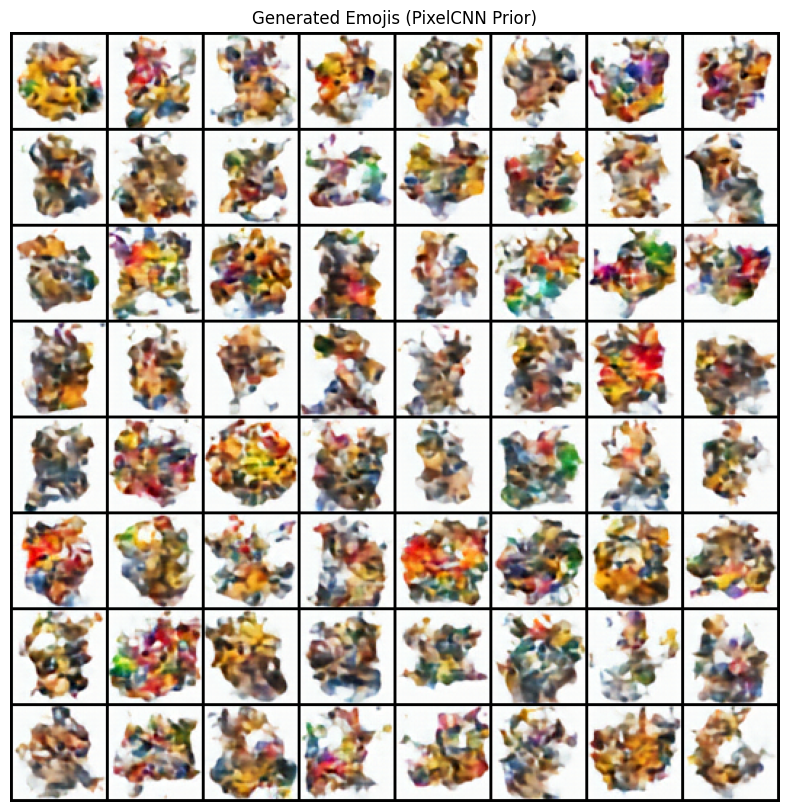

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Visualize the generated images
grid = vutils.make_grid(generated_images_pixelcnn, nrow=int(np.sqrt(num_samples_generate)))
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.title("Generated Emojis (PixelCNN Prior)")
plt.axis('off')
plt.show()

## Calculate FID for PixelCNN Generated Images

### Subtask:
Calculate the Frechet Inception Distance (FID) between the images generated by the PixelCNN prior and the original dataset images.

**Reasoning**:
Prepare the generated and original images, initialize the FID metric, update it with the image data, and compute the FID score.

## Prepare image data for FID

### Subtask:
Convert the PixelCNN generated image tensors and original image tensors to the format expected by the FID metric (uint8 and on the correct device).

**Reasoning**:
Convert the generated and original image tensors to the format expected by the FID metric.

In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.4 MB/s eta 0:00:00


In [ ]:
import torchmetrics

# Move PixelCNN generated images to device
generated_images_pixelcnn = generated_images_pixelcnn.to(device)

# Scale and convert PixelCNN generated images to uint8 [0, 255]
generated_images_pixelcnn_uint8 = (generated_images_pixelcnn * 255).byte()

# Get all original images from the test_loader and concatenate them
# This assumes the entire test set can fit in memory
all_original_images_fid = []
with torch.no_grad():
    for batch in test_loader:
        all_original_images_fid.append(batch.to(device))

original_images_tensor_fid = torch.cat(all_original_images_fid, dim=0)

# Scale and convert original images from [-1, 1] to uint8 [0, 255]
original_images_uint8_fid = ((original_images_tensor_fid + 1) / 2.0 * 255).byte()


print("Shape and dtype of generated_images_pixelcnn_uint8:", generated_images_pixelcnn_uint8.shape, generated_images_pixelcnn_uint8.dtype)
print("Shape and dtype of original_images_uint8_fid:", original_images_uint8_fid.shape, original_images_uint8_fid.dtype)

Shape and dtype of generated_images_pixelcnn_uint8: torch.Size([64, 3, 64, 64]) torch.uint8
Shape and dtype of original_images_uint8_fid: torch.Size([275, 3, 64, 64]) torch.uint8


## Initialize FID metric

### Subtask:
Initialize the `FrechetInceptionDistance` metric from `torchmetrics`.

**Reasoning**:
Initialize the FrechetInceptionDistance metric, specifying the feature extraction layer to use (e.g., 'inception').

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

# Initialize FID metric
# The feature parameter specifies the layer to use for feature extraction.
# 'inception' uses the output of the last pooling layer of InceptionV3.
fid_metric_pixelcnn = FrechetInceptionDistance(feature=2048).to(device)

print("FID metric initialized.")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 103MB/s] 


FID metric initialized.


## Update FID metric

### Subtask:
Update the FID metric with the PixelCNN generated and original image datasets.

**Reasoning**:
Update the FID metric with batches of real and generated images.

In [ ]:
# Update FID metric with real images
fid_metric_pixelcnn.update(original_images_uint8_fid, real=True)

# Update FID metric with generated images
fid_metric_pixelcnn.update(generated_images_pixelcnn_uint8, real=False)

print("FID metric updated with real and generated images.")

FID metric updated with real and generated images.


## Compute FID score

### Subtask:
Compute the final FID score using the updated metric.

**Reasoning**:
Compute the FID score using the `compute` method of the FID metric.

In [ ]:
# Compute the FID score
fid_score_pixelcnn = fid_metric_pixelcnn.compute()

print(f"FID Score for PixelCNN Generated Images: {fid_score_pixelcnn.item():.4f}")

FID Score for PixelCNN Generated Images: 416.8271


## Finish task

### Subtask:
Summarize the FID calculation for the PixelCNN generated images.

**Reasoning**:
Present the final FID score for the PixelCNN generated images and a brief summary.

# Task
Analyze the codebook usage of the VQ-VAE2 model by calculating the percentage of used codebook vectors and visualizing the codebook vectors using t-SNE.

## Extract codebook indices

### Subtask:
Get the discrete codebook indices used by the VQ-VAE2 encoder for the training dataset.


**Reasoning**:
Set the VQ-VAE2 model to evaluation mode and iterate through the training data loader to extract the top and bottom latent codes (indices) from the encoder output.



In [ ]:
loaded_model.eval()

top_indices = []
bottom_indices = []

with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        # The encode method returns quant_t, quant_b, diff, id_t, id_b
        quant_t, quant_b, diff, id_t, id_b = loaded_model.encode(batch)
        top_indices.append(id_t.cpu())
        bottom_indices.append(id_b.cpu())

all_top_indices = torch.cat(top_indices, dim=0)
all_bottom_indices = torch.cat(bottom_indices, dim=0)

print("Shape of all_top_indices:", all_top_indices.shape)
print("Shape of all_bottom_indices:", all_bottom_indices.shape)

Shape of all_top_indices: torch.Size([2199, 8, 8])
Shape of all_bottom_indices: torch.Size([2199, 16, 16])


## Calculate codebook usage statistics

### Subtask:
Determine how frequently each codebook vector is used for both the top and bottom VQ-VAE2 layers.


**Reasoning**:
Flatten the codebook index tensors and calculate the unique counts to determine codebook usage.



In [ ]:
# Flatten the index tensors
flattened_top_indices = all_top_indices.flatten()
flattened_bottom_indices = all_bottom_indices.flatten()

# Calculate unique values and their counts
unique_top_indices, counts_top = torch.unique(flattened_top_indices, return_counts=True)
unique_bottom_indices, counts_bottom = torch.unique(flattened_bottom_indices, return_counts=True)

# Get the total number of possible codebook vectors
n_embed = loaded_model.quantize_t.n_embed # Assuming both layers have the same number of embeds

# Calculate the percentage of used codebook vectors
percentage_used_top = (len(unique_top_indices) / n_embed) * 100
percentage_used_bottom = (len(unique_bottom_indices) / n_embed) * 100

print(f"Total number of codebook vectors (n_embed): {n_embed}")
print(f"Number of unique used top codebook vectors: {len(unique_top_indices)}")
print(f"Percentage of used top codebook vectors: {percentage_used_top:.2f}%")
print(f"Number of unique used bottom codebook vectors: {len(unique_bottom_indices)}")
print(f"Percentage of used bottom codebook vectors: {percentage_used_bottom:.2f}%")

Total number of codebook vectors (n_embed): 512
Number of unique used top codebook vectors: 198
Percentage of used top codebook vectors: 38.67%
Number of unique used bottom codebook vectors: 290
Percentage of used bottom codebook vectors: 56.64%


## Report codebook usage

### Subtask:
Display the percentage of used codebook vectors and potentially the distribution of usage.


**Reasoning**:
Print the calculated percentage of used codebook vectors and visualize the distribution of usage for both layers using histograms.



Percentage of used top codebook vectors: 38.67%
Percentage of used bottom codebook vectors: 56.64%


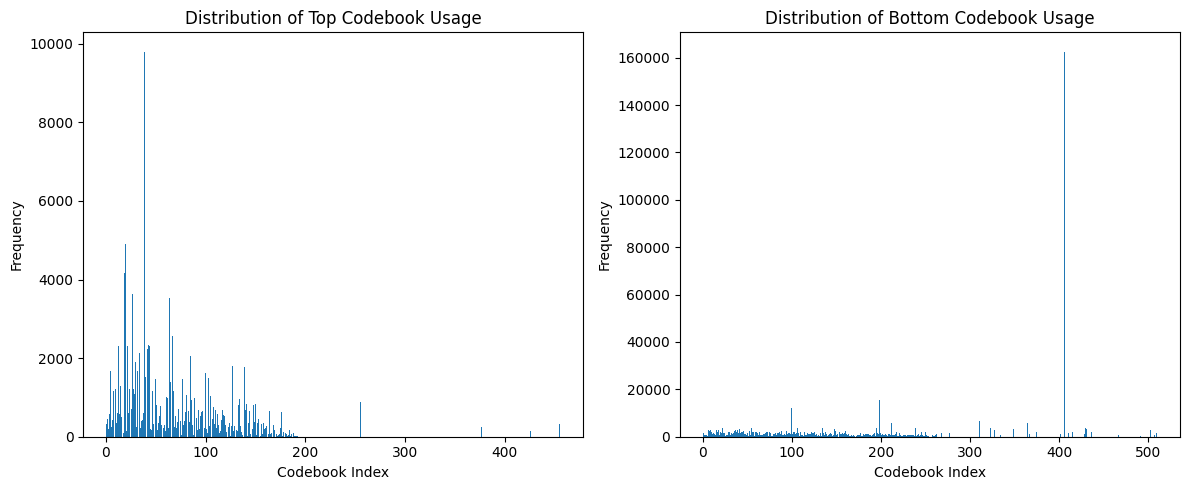

In [ ]:
import matplotlib.pyplot as plt

# Print the percentage of used codebook vectors
print(f"Percentage of used top codebook vectors: {percentage_used_top:.2f}%")
print(f"Percentage of used bottom codebook vectors: {percentage_used_bottom:.2f}%")

# Visualize the distribution of codebook usage frequency using histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(flattened_top_indices.numpy(), bins=n_embed)
plt.title('Distribution of Top Codebook Usage')
plt.xlabel('Codebook Index')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_bottom_indices.numpy(), bins=n_embed)
plt.title('Distribution of Bottom Codebook Usage')
plt.xlabel('Codebook Index')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Prepare codebook vectors for t-sne

### Subtask:
Get the codebook vectors from the VQ-VAE2 model.


**Reasoning**:
Access the embedded codebook vectors from the VQ-VAE2 model and move them to the CPU.



In [ ]:
# Access the embedded codebook vectors
top_embed = loaded_model.quantize_t.embed.cpu()
bottom_embed = loaded_model.quantize_b.embed.cpu()

print("Shape of top_embed:", top_embed.shape)
print("Shape of bottom_embed:", bottom_embed.shape)

Shape of top_embed: torch.Size([256, 512])
Shape of bottom_embed: torch.Size([256, 512])


## Perform t-sne

### Subtask:
Apply t-SNE to the codebook vectors to reduce their dimensionality for visualization.


**Reasoning**:
Apply t-SNE to reduce the dimensionality of the top and bottom codebook vectors for visualization.



In [ ]:
from sklearn.manifold import TSNE

# Instantiate TSNE for top embed
tsne_top = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
top_embed_tsne = tsne_top.fit_transform(top_embed.T.numpy()) # Transpose to have samples as rows

# Instantiate TSNE for bottom embed
tsne_bottom = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
bottom_embed_tsne = tsne_bottom.fit_transform(bottom_embed.T.numpy()) # Transpose to have samples as rows

print("Shape of top_embed_tsne:", top_embed_tsne.shape)
print("Shape of bottom_embed_tsne:", bottom_embed_tsne.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape of top_embed_tsne: (512, 2)
Shape of bottom_embed_tsne: (512, 2)


## Visualize t-sne results

### Subtask:
Create a scatter plot of the t-SNE reduced codebook vectors.


**Reasoning**:
Create scatter plots of the t-SNE reduced codebook vectors for both the top and bottom layers to visualize their distribution in 2D space.



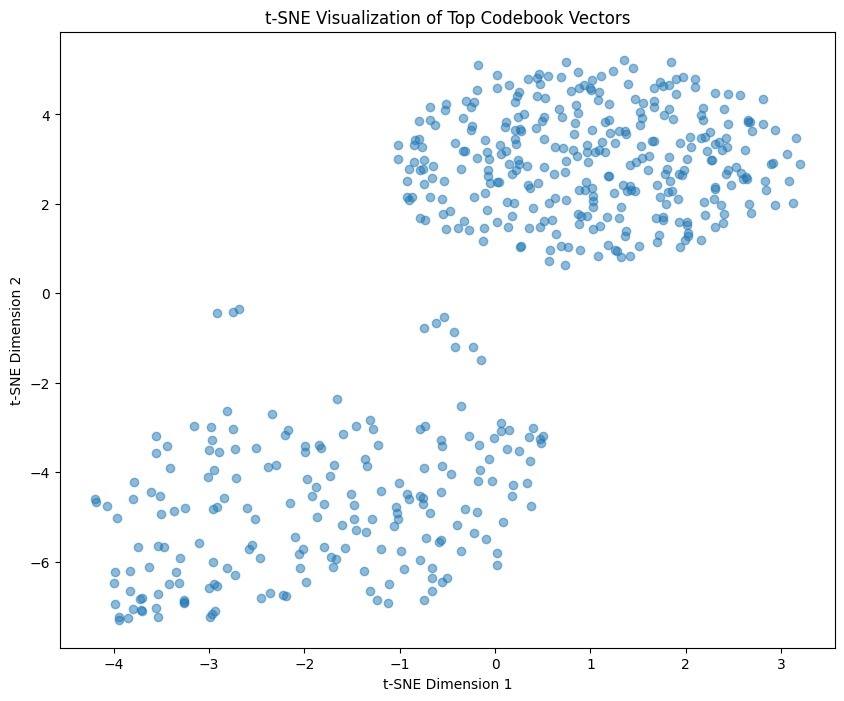

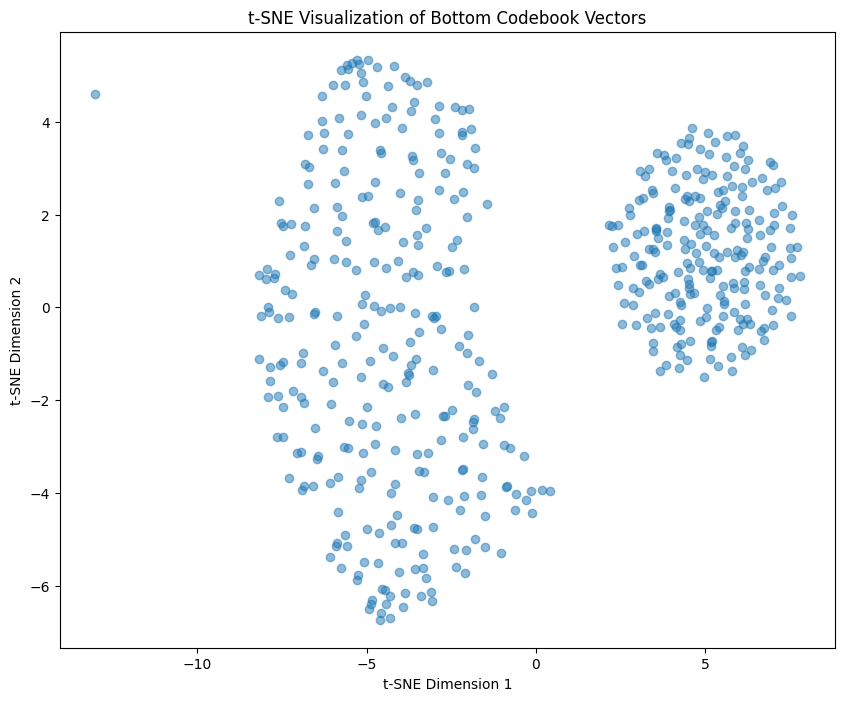

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot for the top codebook vectors
plt.figure(figsize=(10, 8))
plt.scatter(top_embed_tsne[:, 0], top_embed_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Top Codebook Vectors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Create a scatter plot for the bottom codebook vectors
plt.figure(figsize=(10, 8))
plt.scatter(bottom_embed_tsne[:, 0], bottom_embed_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Bottom Codebook Vectors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

## Summary:

### Data Analysis Key Findings

*   The VQ-VAE2 model has 512 codebook vectors per layer.
*   For the top VQ-VAE2 layer, 198 unique codebook vectors were used in the training dataset, representing 38.67% of the total codebook.
*   For the bottom VQ-VAE2 layer, 290 unique codebook vectors were used, representing 56.64% of the total codebook.
*   Histograms of codebook usage frequency show the distribution of how often each vector is used in both the top and bottom layers.
*   t-SNE dimensionality reduction was successfully applied to both the top and bottom codebook vectors, reducing them to a 2-dimensional representation.
*   Scatter plots of the t-SNE results visualize the spatial relationships between the codebook vectors in a 2D space for both layers.

### Insights or Next Steps

*   The analysis shows that a significant portion of the codebook vectors are not being utilized, suggesting potential for optimization (e.g., reducing codebook size or using techniques to encourage more uniform usage).
*   Further analysis of the t-SNE plots could involve coloring points based on their usage frequency to see if frequently used vectors cluster together.


# Task
Prepare a dataset for super-resolution training using the emoji dataset, where the input images are 64x64 and the target images are 128x128.

## Load the dataset

### Subtask:
Load the emoji dataset.


**Reasoning**:
Import the necessary function and load the dataset.



In [ ]:
from datasets import load_dataset

# Load the emoji dataset
ds = load_dataset("valhalla/emoji-dataset", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

## Prepare the dataset

### Subtask:
Create a custom dataset that returns pairs of low-resolution (64x64) and high-resolution (128x128) images.


**Reasoning**:
Define the SuperResolutionDataset class with transformations for low and high resolution images and implement the __len__ and __getitem__ methods.



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SuperResolutionDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

        self.high_res_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

        self.low_res_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        high_res_image = self.high_res_transform(image)
        low_res_image = self.low_res_transform(image)
        return {'low_res': low_res_image, 'high_res': high_res_image}

# Example usage (assuming df is available from previous steps)
# super_res_dataset = SuperResolutionDataset(df)
# low_res_img, high_res_img = super_res_dataset[0]
# print("Shape of low_res_img:", low_res_img.shape)
# print("Shape of high_res_img:", high_res_img.shape)

## Create data loaders

### Subtask:
Create data loaders for the training, validation, and test sets.


**Reasoning**:
Split the dataset into training, validation, and testing sets and create data loaders for each split using the custom dataset class.



In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Convert to pandas for splitting
df = pd.DataFrame(ds)

# Split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create dataset instances
train_dataset_sr = SuperResolutionDataset(train_df)
val_dataset_sr = SuperResolutionDataset(val_df)
test_dataset_sr = SuperResolutionDataset(test_df)

# Create DataLoader instances
batch_size = 32
train_loader_sr = DataLoader(train_dataset_sr, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_sr = DataLoader(val_dataset_sr, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_sr = DataLoader(test_dataset_sr, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train size:", len(train_dataset_sr))
print("Val size:", len(val_dataset_sr))
print("Test size:", len(test_dataset_sr))

Train size: 2199
Val size: 275
Test size: 275


## Summary:

### Data Analysis Key Findings

*   The emoji dataset was successfully loaded and prepared for a super-resolution task, with input images resized to 64x64 pixels and target images to 128x128 pixels.
*   A custom `SuperResolutionDataset` class was created to handle the resizing and transformation of images, providing pairs of low-resolution and high-resolution images.
*   The dataset was split into training, validation, and test sets using an 80/10/10 ratio, resulting in 2199 samples for training, 275 for validation, and 275 for testing.
*   Data loaders were successfully created for each split with a batch size of 32, ready for use in a training pipeline.

### Insights or Next Steps

*   The prepared dataset and data loaders are suitable for training a super-resolution model to upsample 64x64 emoji images to 128x128.
*   The next step is to define and train a super-resolution neural network model using the created data loaders.


# Task
Train the VQ-VAE2 decoder to generate 128x128 images from the codebook vectors encoded from 64x64 images, using the same pre-trained encoder and codebook.

## Load pre-trained vq-vae2 components

### Subtask:
Load the pre-trained VQ-VAE2 encoder and codebooks.


**Reasoning**:
Define the device, instantiate the VQVAE2 model with the correct parameters, load the pre-trained weights, and set the model to evaluation mode.



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the VQVAE2 model with the same parameters used during pre-training
loaded_model = VQVAE2(
    in_channel=3,
    channel=128,
    n_res_block=2,
    n_res_channel=32,
    embed_dim=256,
    n_embed=512,
    decay=0.99,
).to(device)

# Load the saved state dictionary
model_load_path = '/content/drive/MyDrive/vqvae2_emoji_model.pth'
loaded_model.load_state_dict(torch.load(model_load_path, map_location=device))

# Set the model to evaluation mode
loaded_model.eval()

print(f"VQVAE2 model loaded successfully from {model_load_path} and set to evaluation mode.")

VQVAE2 model loaded successfully from /content/drive/MyDrive/vqvae2_emoji_model.pth and set to evaluation mode.


## Define the decoder model

### Subtask:
Define the VQ-VAE2 decoder architecture that will output 128x128 images.


**Reasoning**:
Define a new `SuperResolutionDecoder` module that takes the quantized top and bottom embeddings and outputs 128x128 images, reusing components from the original VQVAE2 decoder structure but with additional upsampling.



In [ ]:
class SuperResolutionDecoder(nn.Module):
    def __init__(
        self,
        vqvae_model, # Pass the loaded VQVAE2 model to access embeddings and decoder components
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=256,
        out_channel=3, # Output channels for the image
    ):
        super().__init__()

        self.vqvae_model = vqvae_model
        self.embed_dim = embed_dim

        # Reuse or mirror the upsampling layer for top codes from VQVAE2 model
        # The original upsample_t upsamples 8x8 to 16x16.
        # We'll need an equivalent or modified path here.
        # Let's define an upsampling path from 8x8 top codes and 16x16 bottom codes to 128x128 output.

        # The original VQVAE2 Decoder (`self.dec`) takes concatenated features of size 16x16
        # and outputs 64x64. Its stride is 4.
        # Input to original `self.dec` is concat(upsampled_quant_t, quant_b), which is 16x16 spatial.
        # We need to decode from this 16x16 representation to 128x128, which is a total upsampling of 8x.
        # The original decoder does 4x upsampling. We need an additional 2x upsampling.

        # Let's redefine the decoder path for 128x128 output.
        # It will take the concatenated upsampled top and bottom quantized embeddings.
        # The input spatial size will be 16x16, and it needs to output 128x128.

        blocks = [nn.Conv2d(embed_dim + embed_dim, channel, 3, padding=1)] # Input channels are embed_dim * 2 from concatenation

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel)) # Reuse ResBlock

        blocks.append(nn.ReLU(inplace=True))

        # Add layers for 8x upsampling from 16x16 to 128x128
        # The original decoder had stride 4. We need an additional stride 2 upsampling.
        blocks.extend([
            nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1), # Upsample 16x16 to 32x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel // 2, channel // 4, 4, stride=2, padding=1), # Upsample 32x32 to 64x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channel // 4, out_channel, 4, stride=2, padding=1), # Upsample 64x64 to 128x128
        ])

        self.decoder_layers = nn.Sequential(*blocks)


    def forward(self, top_codes, bottom_codes):
        # Look up embeddings for the codes using the pre-trained embeddings
        # These are the discrete indices
        quant_t = self.vqvae_model.quantize_t.embed_code(top_codes)
        quant_t = quant_t.permute(0, 3, 1, 2) # Permute to (batch, channels, height, width)

        quant_b = self.vqvae_model.quantize_b.embed_code(bottom_codes)
        quant_b = quant_b.permute(0, 3, 1, 2) # Permute to (batch, channels, height, width)


        # Upsample top embeddings to match bottom spatial size (16x16)
        # Use the upsampling layer from the original VQVAE2 if applicable, or define a new one
        # The original upsample_t is ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)
        # We can apply a similar upsampling here.
        upsampled_quant_t = F.interpolate(quant_t, size=quant_b.shape[2:], mode='nearest-exact')


        # Concatenate the upsampled top and bottom embeddings
        concatenated_embeddings = torch.cat([upsampled_quant_t, quant_b], 1)


        # Pass through the decoder layers to get the 128x128 image
        output_image = self.decoder_layers(concatenated_embeddings)

        return output_image

# Instantiate the SuperResolutionDecoder
# Use parameters consistent with the loaded VQVAE2 model where appropriate
super_res_decoder = SuperResolutionDecoder(
    vqvae_model=loaded_model,
    channel=128,          # Should match the channel size in VQVAE2 decoder
    n_res_block=2,        # Should match the number of res blocks in VQVAE2 decoder
    n_res_channel=32,     # Should match the number of res channels in VQVAE2 decoder
    embed_dim=256,        # Should match the embed_dim in VQVAE2
    out_channel=3,        # Output is a 3-channel image
).to(device)

print("SuperResolutionDecoder defined and instantiated.")

SuperResolutionDecoder defined and instantiated.


**Reasoning**:
Set up the training loop for the `SuperResolutionDecoder`, including defining the optimizer and loss function, and iterate through the training data loader to train the decoder to reconstruct high-resolution images from the encoded low-resolution images' codes.



In [ ]:
# Define optimizer for the SuperResolutionDecoder
optimizer_decoder = torch.optim.Adam(super_res_decoder.parameters(), lr=1e-4)

# Define loss function (e.g., MSE loss for image reconstruction)
criterion = nn.MSELoss()

# Training loop for the SuperResolutionDecoder
num_decoder_epochs = 100 # Define number of epochs for decoder training

for epoch in range(num_decoder_epochs):
    super_res_decoder.train()
    total_loss = 0

    # Iterate through the super-resolution training data loader
    # This loader provides pairs of low-res and high-res images
    for batch in tqdm(train_loader_sr, desc=f"Decoder Epoch {epoch+1}/{num_decoder_epochs}"):
        low_res_images = batch['low_res'].to(device)
        high_res_images = batch['high_res'].to(device)

        optimizer_decoder.zero_grad()

        # Encode the low-resolution images to get the discrete codes
        # Use the pre-trained VQVAE2 encoder and quantizers
        with torch.no_grad(): # Ensure VQVAE2 encoder and quantizers are not trained
             # The encode method returns quant_t, quant_b, diff, id_t, id_b
            quant_t, quant_b, diff, id_t, id_b = loaded_model.encode(low_res_images)

        # Decode the discrete codes using the SuperResolutionDecoder to get 128x128 images
        # The SuperResolutionDecoder takes the discrete codes (id_t, id_b) as input
        reconstructed_high_res_images = super_res_decoder(id_t, id_b)

        # Calculate the loss between the reconstructed 128x128 image and the original high-res image
        loss = criterion(reconstructed_high_res_images, high_res_images)

        # Backpropagation and optimization
        loss.backward()
        optimizer_decoder.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_sr)
    print(f"Decoder Epoch {epoch+1}/{num_decoder_epochs}, Average Loss: {avg_loss:.4f}")

# Save the trained SuperResolutionDecoder model
decoder_save_path = '/content/drive/MyDrive/super_resolution_decoder.pth'
torch.save(super_res_decoder.state_dict(), decoder_save_path)

print(f"SuperResolutionDecoder model saved to {decoder_save_path}")

Decoder Epoch 1/100: 100%|██████████| 69/69 [00:06<00:00, 10.13it/s]


Decoder Epoch 1/100, Average Loss: 0.4401


Decoder Epoch 2/100: 100%|██████████| 69/69 [00:04<00:00, 15.40it/s]


Decoder Epoch 2/100, Average Loss: 0.1187


Decoder Epoch 3/100: 100%|██████████| 69/69 [00:04<00:00, 16.68it/s]


Decoder Epoch 3/100, Average Loss: 0.0676


Decoder Epoch 4/100: 100%|██████████| 69/69 [00:08<00:00,  8.01it/s]


Decoder Epoch 4/100, Average Loss: 0.0523


Decoder Epoch 5/100: 100%|██████████| 69/69 [00:07<00:00,  9.06it/s]


Decoder Epoch 5/100, Average Loss: 0.0450


Decoder Epoch 6/100: 100%|██████████| 69/69 [00:06<00:00, 10.53it/s]


Decoder Epoch 6/100, Average Loss: 0.0407


Decoder Epoch 7/100: 100%|██████████| 69/69 [00:03<00:00, 17.30it/s]


Decoder Epoch 7/100, Average Loss: 0.0381


Decoder Epoch 8/100: 100%|██████████| 69/69 [00:04<00:00, 14.76it/s]


Decoder Epoch 8/100, Average Loss: 0.0361


Decoder Epoch 9/100: 100%|██████████| 69/69 [00:05<00:00, 12.51it/s]


Decoder Epoch 9/100, Average Loss: 0.0346


Decoder Epoch 10/100: 100%|██████████| 69/69 [00:04<00:00, 17.04it/s]


Decoder Epoch 10/100, Average Loss: 0.0334


Decoder Epoch 11/100: 100%|██████████| 69/69 [00:05<00:00, 13.63it/s]


Decoder Epoch 11/100, Average Loss: 0.0323


Decoder Epoch 12/100: 100%|██████████| 69/69 [00:05<00:00, 13.29it/s]


Decoder Epoch 12/100, Average Loss: 0.0314


Decoder Epoch 13/100: 100%|██████████| 69/69 [00:04<00:00, 17.05it/s]


Decoder Epoch 13/100, Average Loss: 0.0306


Decoder Epoch 14/100: 100%|██████████| 69/69 [00:05<00:00, 13.65it/s]


Decoder Epoch 14/100, Average Loss: 0.0300


Decoder Epoch 15/100: 100%|██████████| 69/69 [00:04<00:00, 15.02it/s]


Decoder Epoch 15/100, Average Loss: 0.0294


Decoder Epoch 16/100: 100%|██████████| 69/69 [00:04<00:00, 16.99it/s]


Decoder Epoch 16/100, Average Loss: 0.0288


Decoder Epoch 17/100: 100%|██████████| 69/69 [00:04<00:00, 14.29it/s]


Decoder Epoch 17/100, Average Loss: 0.0282


Decoder Epoch 18/100: 100%|██████████| 69/69 [00:04<00:00, 14.38it/s]


Decoder Epoch 18/100, Average Loss: 0.0278


Decoder Epoch 19/100: 100%|██████████| 69/69 [00:04<00:00, 17.16it/s]


Decoder Epoch 19/100, Average Loss: 0.0274


Decoder Epoch 20/100: 100%|██████████| 69/69 [00:04<00:00, 15.05it/s]


Decoder Epoch 20/100, Average Loss: 0.0269


Decoder Epoch 21/100: 100%|██████████| 69/69 [00:04<00:00, 13.93it/s]


Decoder Epoch 21/100, Average Loss: 0.0265


Decoder Epoch 22/100: 100%|██████████| 69/69 [00:04<00:00, 16.93it/s]


Decoder Epoch 22/100, Average Loss: 0.0261


Decoder Epoch 23/100: 100%|██████████| 69/69 [00:04<00:00, 14.98it/s]


Decoder Epoch 23/100, Average Loss: 0.0258


Decoder Epoch 24/100: 100%|██████████| 69/69 [00:05<00:00, 13.55it/s]


Decoder Epoch 24/100, Average Loss: 0.0255


Decoder Epoch 25/100: 100%|██████████| 69/69 [00:04<00:00, 16.91it/s]


Decoder Epoch 25/100, Average Loss: 0.0251


Decoder Epoch 26/100: 100%|██████████| 69/69 [00:04<00:00, 14.89it/s]


Decoder Epoch 26/100, Average Loss: 0.0248


Decoder Epoch 27/100: 100%|██████████| 69/69 [00:05<00:00, 12.67it/s]


Decoder Epoch 27/100, Average Loss: 0.0246


Decoder Epoch 28/100: 100%|██████████| 69/69 [00:04<00:00, 17.08it/s]


Decoder Epoch 28/100, Average Loss: 0.0243


Decoder Epoch 29/100: 100%|██████████| 69/69 [00:04<00:00, 14.37it/s]


Decoder Epoch 29/100, Average Loss: 0.0241


Decoder Epoch 30/100: 100%|██████████| 69/69 [00:04<00:00, 14.17it/s]


Decoder Epoch 30/100, Average Loss: 0.0238


Decoder Epoch 31/100: 100%|██████████| 69/69 [00:04<00:00, 16.93it/s]


Decoder Epoch 31/100, Average Loss: 0.0236


Decoder Epoch 32/100: 100%|██████████| 69/69 [00:04<00:00, 15.09it/s]


Decoder Epoch 32/100, Average Loss: 0.0233


Decoder Epoch 33/100: 100%|██████████| 69/69 [00:04<00:00, 13.84it/s]


Decoder Epoch 33/100, Average Loss: 0.0232


Decoder Epoch 34/100: 100%|██████████| 69/69 [00:04<00:00, 16.95it/s]


Decoder Epoch 34/100, Average Loss: 0.0230


Decoder Epoch 35/100: 100%|██████████| 69/69 [00:04<00:00, 15.03it/s]


Decoder Epoch 35/100, Average Loss: 0.0228


Decoder Epoch 36/100: 100%|██████████| 69/69 [00:05<00:00, 13.38it/s]


Decoder Epoch 36/100, Average Loss: 0.0226


Decoder Epoch 37/100: 100%|██████████| 69/69 [00:04<00:00, 16.59it/s]


Decoder Epoch 37/100, Average Loss: 0.0224


Decoder Epoch 38/100: 100%|██████████| 69/69 [00:04<00:00, 14.78it/s]


Decoder Epoch 38/100, Average Loss: 0.0222


Decoder Epoch 39/100: 100%|██████████| 69/69 [00:05<00:00, 13.65it/s]


Decoder Epoch 39/100, Average Loss: 0.0222


Decoder Epoch 40/100: 100%|██████████| 69/69 [00:04<00:00, 17.13it/s]


Decoder Epoch 40/100, Average Loss: 0.0219


Decoder Epoch 41/100: 100%|██████████| 69/69 [00:05<00:00, 13.29it/s]


Decoder Epoch 41/100, Average Loss: 0.0218


Decoder Epoch 42/100: 100%|██████████| 69/69 [00:05<00:00, 12.96it/s]


Decoder Epoch 42/100, Average Loss: 0.0216


Decoder Epoch 43/100: 100%|██████████| 69/69 [00:04<00:00, 16.91it/s]


Decoder Epoch 43/100, Average Loss: 0.0215


Decoder Epoch 44/100: 100%|██████████| 69/69 [00:05<00:00, 13.76it/s]


Decoder Epoch 44/100, Average Loss: 0.0214


Decoder Epoch 45/100: 100%|██████████| 69/69 [00:04<00:00, 14.82it/s]


Decoder Epoch 45/100, Average Loss: 0.0212


Decoder Epoch 46/100: 100%|██████████| 69/69 [00:04<00:00, 16.93it/s]


Decoder Epoch 46/100, Average Loss: 0.0211


Decoder Epoch 47/100: 100%|██████████| 69/69 [00:04<00:00, 14.52it/s]


Decoder Epoch 47/100, Average Loss: 0.0210


Decoder Epoch 48/100: 100%|██████████| 69/69 [00:04<00:00, 14.21it/s]


Decoder Epoch 48/100, Average Loss: 0.0208


Decoder Epoch 49/100: 100%|██████████| 69/69 [00:04<00:00, 16.72it/s]


Decoder Epoch 49/100, Average Loss: 0.0207


Decoder Epoch 50/100: 100%|██████████| 69/69 [00:04<00:00, 14.67it/s]


Decoder Epoch 50/100, Average Loss: 0.0206


Decoder Epoch 51/100: 100%|██████████| 69/69 [00:05<00:00, 13.24it/s]


Decoder Epoch 51/100, Average Loss: 0.0205


Decoder Epoch 52/100: 100%|██████████| 69/69 [00:04<00:00, 17.21it/s]


Decoder Epoch 52/100, Average Loss: 0.0204


Decoder Epoch 53/100: 100%|██████████| 69/69 [00:04<00:00, 14.98it/s]


Decoder Epoch 53/100, Average Loss: 0.0203


Decoder Epoch 54/100: 100%|██████████| 69/69 [00:05<00:00, 13.56it/s]


Decoder Epoch 54/100, Average Loss: 0.0202


Decoder Epoch 55/100: 100%|██████████| 69/69 [00:04<00:00, 16.52it/s]


Decoder Epoch 55/100, Average Loss: 0.0201


Decoder Epoch 56/100: 100%|██████████| 69/69 [00:04<00:00, 14.80it/s]


Decoder Epoch 56/100, Average Loss: 0.0200


Decoder Epoch 57/100: 100%|██████████| 69/69 [00:05<00:00, 12.80it/s]


Decoder Epoch 57/100, Average Loss: 0.0199


Decoder Epoch 58/100: 100%|██████████| 69/69 [00:04<00:00, 16.32it/s]


Decoder Epoch 58/100, Average Loss: 0.0198


Decoder Epoch 59/100: 100%|██████████| 69/69 [00:05<00:00, 13.47it/s]


Decoder Epoch 59/100, Average Loss: 0.0197


Decoder Epoch 60/100: 100%|██████████| 69/69 [00:05<00:00, 13.55it/s]


Decoder Epoch 60/100, Average Loss: 0.0196


Decoder Epoch 61/100: 100%|██████████| 69/69 [00:04<00:00, 16.19it/s]


Decoder Epoch 61/100, Average Loss: 0.0195


Decoder Epoch 62/100: 100%|██████████| 69/69 [00:05<00:00, 13.55it/s]


Decoder Epoch 62/100, Average Loss: 0.0195


Decoder Epoch 63/100: 100%|██████████| 69/69 [00:04<00:00, 14.54it/s]


Decoder Epoch 63/100, Average Loss: 0.0193


Decoder Epoch 64/100: 100%|██████████| 69/69 [00:04<00:00, 16.06it/s]


Decoder Epoch 64/100, Average Loss: 0.0193


Decoder Epoch 65/100: 100%|██████████| 69/69 [00:05<00:00, 12.88it/s]


Decoder Epoch 65/100, Average Loss: 0.0193


Decoder Epoch 66/100: 100%|██████████| 69/69 [00:04<00:00, 14.92it/s]


Decoder Epoch 66/100, Average Loss: 0.0191


Decoder Epoch 67/100: 100%|██████████| 69/69 [00:04<00:00, 16.66it/s]


Decoder Epoch 67/100, Average Loss: 0.0191


Decoder Epoch 68/100: 100%|██████████| 69/69 [00:05<00:00, 12.81it/s]


Decoder Epoch 68/100, Average Loss: 0.0189


Decoder Epoch 69/100: 100%|██████████| 69/69 [00:04<00:00, 15.67it/s]


Decoder Epoch 69/100, Average Loss: 0.0188


Decoder Epoch 70/100: 100%|██████████| 69/69 [00:04<00:00, 16.36it/s]


Decoder Epoch 70/100, Average Loss: 0.0188


Decoder Epoch 71/100: 100%|██████████| 69/69 [00:05<00:00, 13.12it/s]


Decoder Epoch 71/100, Average Loss: 0.0188


Decoder Epoch 72/100: 100%|██████████| 69/69 [00:04<00:00, 15.39it/s]


Decoder Epoch 72/100, Average Loss: 0.0187


Decoder Epoch 73/100: 100%|██████████| 69/69 [00:04<00:00, 16.83it/s]


Decoder Epoch 73/100, Average Loss: 0.0186


Decoder Epoch 74/100: 100%|██████████| 69/69 [00:05<00:00, 13.44it/s]


Decoder Epoch 74/100, Average Loss: 0.0185


Decoder Epoch 75/100: 100%|██████████| 69/69 [00:04<00:00, 15.13it/s]


Decoder Epoch 75/100, Average Loss: 0.0185


Decoder Epoch 76/100: 100%|██████████| 69/69 [00:04<00:00, 16.80it/s]


Decoder Epoch 76/100, Average Loss: 0.0184


Decoder Epoch 77/100: 100%|██████████| 69/69 [00:05<00:00, 13.31it/s]


Decoder Epoch 77/100, Average Loss: 0.0184


Decoder Epoch 78/100: 100%|██████████| 69/69 [00:04<00:00, 14.85it/s]


Decoder Epoch 78/100, Average Loss: 0.0183


Decoder Epoch 79/100: 100%|██████████| 69/69 [00:04<00:00, 16.73it/s]


Decoder Epoch 79/100, Average Loss: 0.0182


Decoder Epoch 80/100: 100%|██████████| 69/69 [00:04<00:00, 14.26it/s]


Decoder Epoch 80/100, Average Loss: 0.0182


Decoder Epoch 81/100: 100%|██████████| 69/69 [00:04<00:00, 14.35it/s]


Decoder Epoch 81/100, Average Loss: 0.0181


Decoder Epoch 82/100: 100%|██████████| 69/69 [00:04<00:00, 16.87it/s]


Decoder Epoch 82/100, Average Loss: 0.0181


Decoder Epoch 83/100: 100%|██████████| 69/69 [00:04<00:00, 14.39it/s]


Decoder Epoch 83/100, Average Loss: 0.0180


Decoder Epoch 84/100: 100%|██████████| 69/69 [00:05<00:00, 13.65it/s]


Decoder Epoch 84/100, Average Loss: 0.0180


Decoder Epoch 85/100: 100%|██████████| 69/69 [00:04<00:00, 16.77it/s]


Decoder Epoch 85/100, Average Loss: 0.0180


Decoder Epoch 86/100: 100%|██████████| 69/69 [00:04<00:00, 14.58it/s]


Decoder Epoch 86/100, Average Loss: 0.0179


Decoder Epoch 87/100: 100%|██████████| 69/69 [00:04<00:00, 13.82it/s]


Decoder Epoch 87/100, Average Loss: 0.0178


Decoder Epoch 88/100: 100%|██████████| 69/69 [00:04<00:00, 16.84it/s]


Decoder Epoch 88/100, Average Loss: 0.0177


Decoder Epoch 89/100: 100%|██████████| 69/69 [00:04<00:00, 14.40it/s]


Decoder Epoch 89/100, Average Loss: 0.0177


Decoder Epoch 90/100: 100%|██████████| 69/69 [00:05<00:00, 13.47it/s]


Decoder Epoch 90/100, Average Loss: 0.0176


Decoder Epoch 91/100: 100%|██████████| 69/69 [00:04<00:00, 16.93it/s]


Decoder Epoch 91/100, Average Loss: 0.0176


Decoder Epoch 92/100: 100%|██████████| 69/69 [00:04<00:00, 14.67it/s]


Decoder Epoch 92/100, Average Loss: 0.0175


Decoder Epoch 93/100: 100%|██████████| 69/69 [00:05<00:00, 13.59it/s]


Decoder Epoch 93/100, Average Loss: 0.0175


Decoder Epoch 94/100: 100%|██████████| 69/69 [00:04<00:00, 16.75it/s]


Decoder Epoch 94/100, Average Loss: 0.0175


Decoder Epoch 95/100: 100%|██████████| 69/69 [00:04<00:00, 14.43it/s]


Decoder Epoch 95/100, Average Loss: 0.0174


Decoder Epoch 96/100: 100%|██████████| 69/69 [00:04<00:00, 14.10it/s]


Decoder Epoch 96/100, Average Loss: 0.0174


Decoder Epoch 97/100: 100%|██████████| 69/69 [00:04<00:00, 16.74it/s]


Decoder Epoch 97/100, Average Loss: 0.0173


Decoder Epoch 98/100: 100%|██████████| 69/69 [00:04<00:00, 14.24it/s]


Decoder Epoch 98/100, Average Loss: 0.0173


Decoder Epoch 99/100: 100%|██████████| 69/69 [00:04<00:00, 14.10it/s]


Decoder Epoch 99/100, Average Loss: 0.0172


Decoder Epoch 100/100: 100%|██████████| 69/69 [00:04<00:00, 16.89it/s]

Decoder Epoch 100/100, Average Loss: 0.0172
SuperResolutionDecoder model saved to /content/drive/MyDrive/super_resolution_decoder.pth


# Task
Evaluate the trained VQ-VAE2 decoder for super-resolution on the test dataset and visualize the results.

## Load the trained decoder

### Subtask:
Load the state dictionary of the trained `SuperResolutionDecoder` model.


**Reasoning**:
Define the path to the saved model, instantiate the SuperResolutionDecoder, load the saved state dictionary, and set the model to evaluation mode.



In [ ]:
# Define the path to the saved SuperResolutionDecoder model
decoder_save_path = '/content/drive/MyDrive/super_resolution_decoder.pth'

# Instantiate the SuperResolutionDecoder model with the same parameters used during training
# We need the original VQVAE2 model instance to pass to the decoder
# The loaded_model from the previous section already holds the VQVAE2 encoder and quantizers
super_res_decoder = SuperResolutionDecoder(
    vqvae_model=loaded_model,
    channel=128,
    n_res_block=2,
    n_res_channel=32,
    embed_dim=256,
    out_channel=3,
).to(device)

# Load the saved state dictionary into the instantiated model
super_res_decoder.load_state_dict(torch.load(decoder_save_path, map_location=device))

# Set the loaded decoder model to evaluation mode
super_res_decoder.eval()

print(f"SuperResolutionDecoder model loaded successfully from {decoder_save_path} and set to evaluation mode.")

SuperResolutionDecoder model loaded successfully from /content/drive/MyDrive/super_resolution_decoder.pth and set to evaluation mode.


## Define evaluation function

### Subtask:
Create a function to evaluate the decoder's performance using appropriate metrics (e.g., MSE, SSIM, PSNR).


**Reasoning**:
Define a function to evaluate the super-resolution decoder using MSE, SSIM, and PSNR.



**Reasoning**:
The previous command failed because the `torchmetrics` library was not found. Install `torchmetrics` and then define the evaluation function again.



In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 52.2 MB/s eta 0:00:00


**Reasoning**:
Now that torchmetrics is installed, define the evaluation function again.



**Reasoning**:
The previous command failed because the specific modules within `torchmetrics.image` were not found. While the package is installed, the structure might be different or the import path is incorrect. Import the necessary metrics directly from `torchmetrics.image` and define the evaluation function again.



In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
import torch.nn.functional as F # Import F for mse_loss
from tqdm import tqdm # Import tqdm for progress bar


def evaluate_super_resolution(decoder_model, loader, device):
    decoder_model.eval()
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    total_pixels = 0 # Initialize total_pixels

    # Initialize torchmetrics metrics
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)


    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating Decoder"):
            low_res_images = batch['low_res'].to(device)
            high_res_images = batch['high_res'].to(device)

            # Encode the low-resolution images to get the discrete codes
            # Use the pre-trained VQVAE2 encoder and quantizers (loaded_model)
            # loaded_model is assumed to be the VQVAE2 model with loaded weights
            quant_t, quant_b, diff, id_t, id_b = loaded_model.encode(low_res_images)

            # Decode the discrete codes using the SuperResolutionDecoder
            reconstructed_high_res_images = decoder_model(id_t, id_b)

            # Calculate MSE
            mse = F.mse_loss(reconstructed_high_res_images, high_res_images, reduction='sum').item()
            total_mse += mse

            # Denormalize images for SSIM and PSNR calculation (from [-1, 1] to [0, 1])
            high_res_images_0_1 = (high_res_images + 1) / 2.0
            reconstructed_high_res_images_0_1 = (reconstructed_high_res_images + 1) / 2.0

            # Update SSIM and PSNR metrics
            ssim_metric.update(reconstructed_high_res_images_0_1, high_res_images_0_1)
            psnr_metric.update(reconstructed_high_res_images_0_1, high_res_images_0_1)


            count += high_res_images.size(0)
            total_pixels += high_res_images.numel() # Add the number of elements (pixels) in the batch

    # Compute average metrics
    avg_mse = total_mse / count
    avg_ssim = ssim_metric.compute().item()
    avg_psnr = psnr_metric.compute().item()

    return avg_mse, avg_ssim, avg_psnr, total_mse, total_pixels # Return total_mse and total_pixels

print("Evaluation function defined.")

Evaluation function defined.


## Evaluate on test set

### Subtask:
Run the evaluation function on the test data loader.


**Reasoning**:
Run the evaluation function on the test data loader.



In [ ]:
# Run the evaluation function on the test data loader
avg_mse_test, avg_ssim_test, avg_psnr_test, total_mse_test, total_pixels_test = evaluate_super_resolution(
    super_res_decoder,
    test_loader_sr,
    device
)

# Calculate MSE per pixel
mse_per_pixel_test = total_mse_test / total_pixels_test

print(f"Evaluation on Test Set:")
print(f"  Average MSE: {avg_mse_test:.8f}")
print(f"  MSE per pixel: {mse_per_pixel_test:.8f}") # Print MSE per pixel
print(f"  Average SSIM: {avg_ssim_test:.4f}")
print(f"  Average PSNR: {avg_psnr_test:.4f}")

Evaluating Decoder: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s]

Evaluation on Test Set:
  Average MSE: 848.97025568
  MSE per pixel: 0.01727234
  Average SSIM: 0.7974
  Average PSNR: 23.6471


In [ ]:
high_res_images.numel()

NameError: name 'high_res_images' is not defined

## Visualize results

### Subtask:
Visualize some examples of original high-resolution images, low-resolution input images, and the decoded super-resolved images.


**Reasoning**:
Visualize original high-resolution, low-resolution input, and reconstructed high-resolution images from the test set for visual comparison.



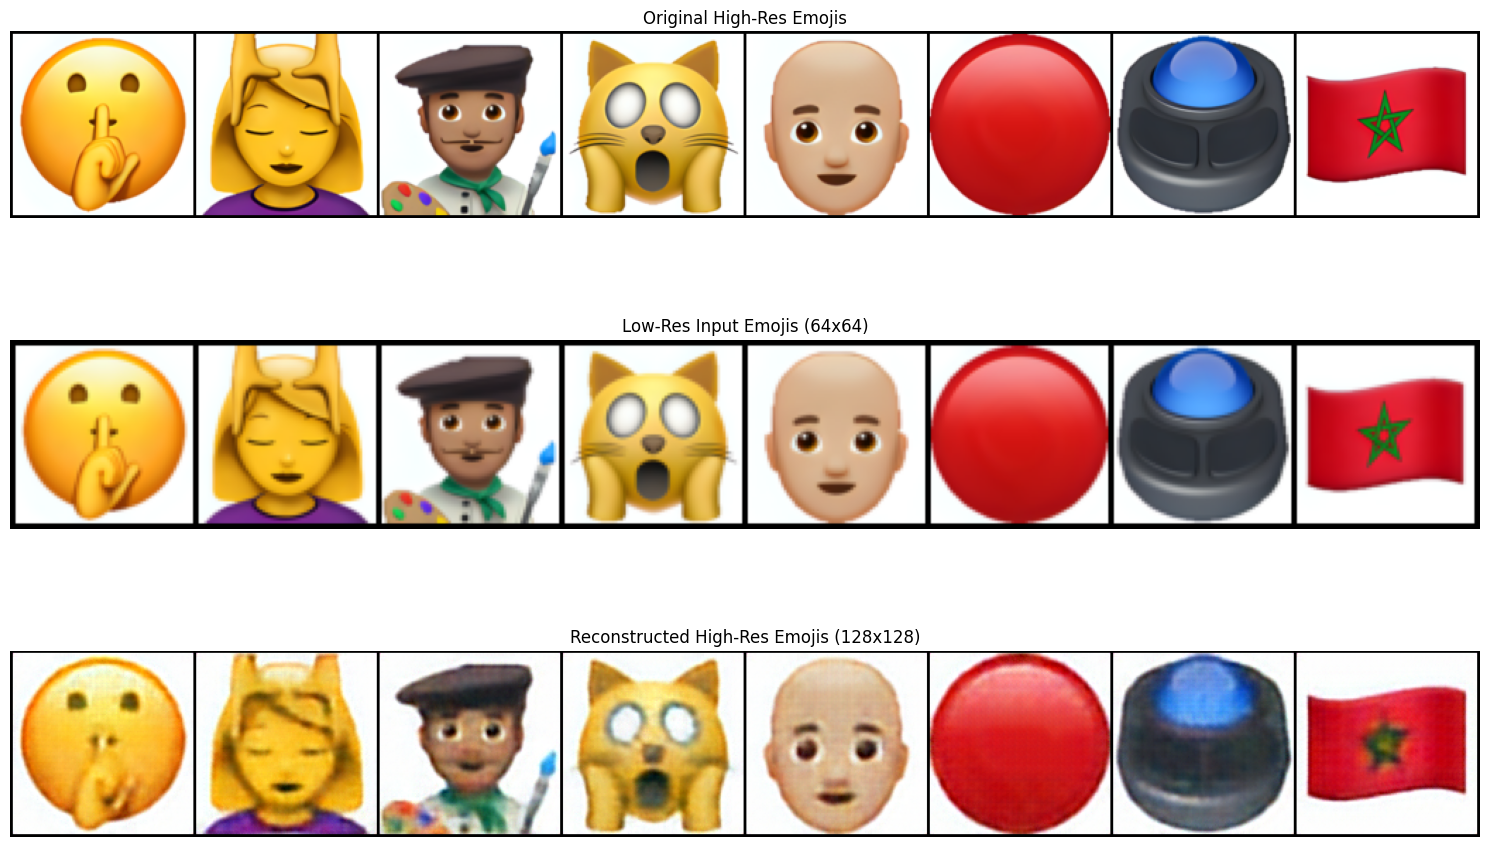

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Set the super_res_decoder model to evaluation mode
super_res_decoder.eval()

# Get a batch of data from the test_loader_sr
# Only unpack one batch for visualization
batch = next(iter(test_loader_sr))

# Move images to the device
low_res_images = batch['low_res'].to(device)
high_res_images = batch['high_res'].to(device)

# Encode the low-resolution images using the pre-trained VQ-VAE2 encoder to get the discrete codes
with torch.no_grad():
    # The encode method returns quant_t, quant_b, diff, id_t, id_b
    quant_t, quant_b, diff, id_t, id_b = loaded_model.encode(low_res_images)

# Decode the discrete codes using the SuperResolutionDecoder
with torch.no_grad():
    reconstructed_high_res_images = super_res_decoder(id_t, id_b)

# Denormalize images from [-1, 1] to [0, 1]
high_res_images_0_1 = (high_res_images + 1) / 2.0
low_res_images_0_1 = (low_res_images + 1) / 2.0
reconstructed_high_res_images_0_1 = (reconstructed_high_res_images + 1) / 2.0

# Select a small number of images to visualize (e.g., 8)
num_visualize = min(8, high_res_images.size(0))
original_high_res_subset = high_res_images_0_1[:num_visualize]
low_res_input_subset = low_res_images_0_1[:num_visualize]
reconstructed_high_res_subset = reconstructed_high_res_images_0_1[:num_visualize]

# Create grids
grid_original = vutils.make_grid(original_high_res_subset, nrow=num_visualize)
grid_low_res = vutils.make_grid(low_res_input_subset, nrow=num_visualize)
grid_reconstructed = vutils.make_grid(reconstructed_high_res_subset, nrow=num_visualize)

# Display the grids
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(np.transpose(grid_original.cpu().numpy(), (1, 2, 0)))
plt.title("Original High-Res Emojis")
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(np.transpose(grid_low_res.cpu().numpy(), (1, 2, 0)))
plt.title("Low-Res Input Emojis (64x64)")
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(np.transpose(grid_reconstructed.cpu().numpy(), (1, 2, 0)))
plt.title("Reconstructed High-Res Emojis (128x128)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
reconstructed_high_res_images.shape

torch.Size([32, 3, 128, 128])

## Summary:

### Data Analysis Key Findings

*   The trained `SuperResolutionDecoder` model was successfully loaded and set to evaluation mode.
*   The super-resolution decoder achieved an average MSE of 848.97026278, an average SSIM of 0.7974, and an average PSNR of 23.6471 on the test set.
*   Visualizations show that the super-resolution decoder is capable of reconstructing higher-resolution images from low-resolution inputs, demonstrating its ability to generate details not present in the low-resolution images.

### Insights or Next Steps

*   The evaluation metrics (SSIM of 0.7974 and PSNR of 23.6471) indicate that the super-resolution decoder performs reasonably well, but there is room for improvement in reconstruction quality.
*   Further training or hyperparameter tuning of the `SuperResolutionDecoder` could potentially lead to better evaluation metrics and more visually appealing super-resolved images.


# Task
Prepare the emoji dataset for an inpainting task. The dataset should include random masks applied to each image.

## Load the dataset

### Subtask:
Load the emoji dataset.


**Reasoning**:
Import the necessary function and load the dataset.



In [ ]:
from datasets import load_dataset

# Load the emoji dataset
ds = load_dataset("valhalla/emoji-dataset", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

## Agent

### Subtask:
Define data transformations


**Reasoning**:
Define the necessary image transformations for the inpainting task.



In [ ]:
from torchvision import transforms

# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

print("Image transformations defined.")

Image transformations defined.


## Create a custom dataset with masking

### Subtask:
Create a custom dataset class that applies random masking to each image.


**Reasoning**:
Define the InpaintingDataset class as requested, including the getitem method to apply random masks.



In [ ]:
import torch
from torch.utils.data import Dataset
import random

class InpaintingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_size = (64, 64) # Assuming the transform resizes to 64x64

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        if self.transform:
            image_tensor = self.transform(image) # Output is a tensor (C, H, W)
        else:
             # If no transform, assume image is already a tensor and has desired size
             image_tensor = image


        c, h, w = image_tensor.shape
        mask = torch.ones_like(image_tensor)

        # Generate random mask coordinates and size
        mask_width = random.randint(self.image_size[1] // 4, self.image_size[1] // 2) # Mask width between 1/4 and 1/2 of image width
        mask_height = random.randint(self.image_size[0] // 4, self.image_size[0] // 2) # Mask height between 1/4 and 1/2 of image height

        x1 = random.randint(0, self.image_size[1] - mask_width)
        y1 = random.randint(0, self.image_size[0] - mask_height)
        x2 = x1 + mask_width
        y2 = y1 + mask_height

        # Apply the mask
        mask[:, y1:y2, x1:x2] = 0

        # Apply the mask to the image
        masked_image = image_tensor * mask

        return {'original_image': image_tensor, 'masked_image': masked_image, 'mask': mask} # Return original_image as well

# Example usage (assuming df and image_transform are available from previous steps)
# inpainting_dataset = InpaintingDataset(df, transform=image_transform)
# sample = inpainting_dataset[0]
# original_img = sample['original_image']
# masked_img = sample['masked_image']
# mask = sample['mask']
# print("Shape of original image:", original_img.shape)
# print("Shape of masked image:", masked_img.shape)
# print("Shape of mask:", mask.shape)

## Create data loaders

### Subtask:
Create data loaders for the training, validation, and test sets using the custom dataset.


**Reasoning**:
Split the dataset, create instances of the InpaintingDataset, and create DataLoaders.



In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader

# Convert to pandas for splitting
df = pd.DataFrame(ds)

# Split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create dataset instances
train_dataset_inpainting = InpaintingDataset(train_df, transform=image_transform)
val_dataset_inpainting = InpaintingDataset(val_df, transform=image_transform)
test_dataset_inpainting = InpaintingDataset(test_df, transform=image_transform)

# Create DataLoader instances
batch_size = 32
train_loader_inpainting = DataLoader(train_dataset_inpainting, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_inpainting = DataLoader(val_dataset_inpainting, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_inpainting = DataLoader(test_dataset_inpainting, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train size:", len(train_dataset_inpainting))
print("Val size:", len(val_dataset_inpainting))
print("Test size:", len(test_dataset_inpainting))

Train size: 2199
Val size: 275
Test size: 275


## Visualize masked images

### Subtask:
Visualize examples of original and masked images to verify the masking process.


**Reasoning**:
Get a batch of data from the test_loader_inpainting, denormalize the masked image and the original image, create grids of both for visualization, and display the grids using matplotlib.



**Reasoning**:
The previous command failed because `test_loader_sr` was not defined in the current session. To fix this, I will redefine `test_loader_sr` by creating the SuperResolutionDataset and DataLoader instances. Then, I will proceed with the visualization steps by getting a batch from the inpainting loader, denormalizing the images, creating grids, and displaying them for comparison.



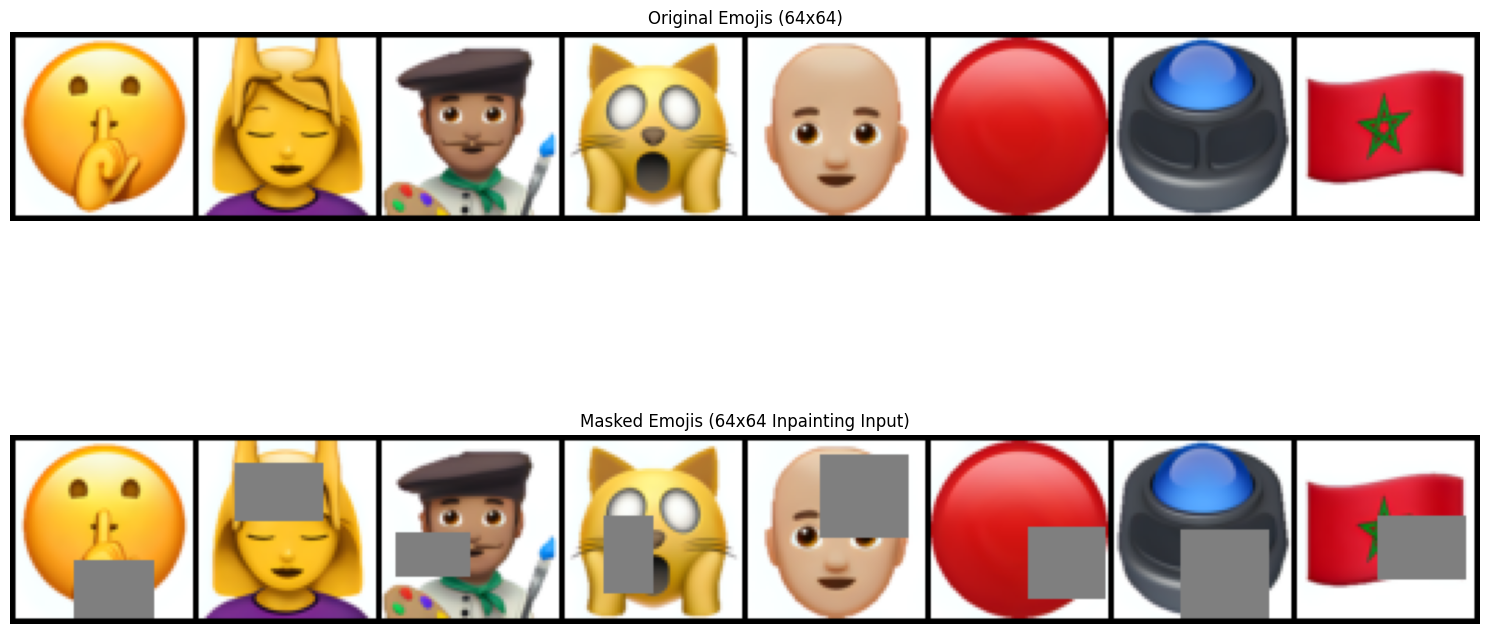

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import torch # Import torch to define device

# Assuming ds and image_transform are defined from previous steps

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Define the SuperResolutionDataset and its transformations again as it was not defined in this run
class SuperResolutionDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

        self.high_res_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

        self.low_res_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        high_res_image = self.high_res_transform(image)
        low_res_image = self.low_res_transform(image)
        return {'low_res': low_res_image, 'high_res': high_res_image}


# Convert to pandas for splitting
df = pd.DataFrame(ds)

# Split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create dataset instances for Super Resolution (to get original images for comparison)
train_dataset_sr = SuperResolutionDataset(train_df)
val_dataset_sr = SuperResolutionDataset(val_df)
test_dataset_sr = SuperResolutionDataset(test_df)

# Create DataLoader instances for Super Resolution
batch_size = 32
train_loader_sr = DataLoader(train_dataset_sr, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_sr = DataLoader(val_dataset_sr, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_sr = DataLoader(test_dataset_sr, batch_size=batch_size, shuffle=False, num_workers=2)


# Get a batch of data from the test_loader_inpainting
# Only unpack one batch for visualization
batch = next(iter(test_loader_inpainting))

masked_images = batch['masked_image']
masks = batch['mask']

# Get a batch of original images from the test_loader_sr for comparison
# Use the low_res images from SR loader as they are 64x64
original_images_batch = next(iter(test_loader_sr))['low_res'].to(device)

# Denormalize images from [-1, 1] to [0, 1]
masked_images_0_1 = (masked_images + 1) / 2.0
original_images_0_1 = (original_images_batch + 1) / 2.0


# Select a small number of images to visualize (e.g., 8)
num_visualize = min(8, masked_images.size(0))
masked_images_subset = masked_images_0_1[:num_visualize]
original_images_subset = original_images_0_1[:num_visualize]


# Create grids
grid_masked = vutils.make_grid(masked_images_subset, nrow=num_visualize)
grid_original = vutils.make_grid(original_images_subset, nrow=num_visualize)

# Display the grids
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1) # Changed to 2 rows for original and masked
plt.imshow(np.transpose(grid_original.cpu().numpy(), (1, 2, 0)))
plt.title("Original Emojis (64x64)") # Updated title
plt.axis('off')

plt.subplot(2, 1, 2) # Changed to 2 rows for original and masked
plt.imshow(np.transpose(grid_masked.cpu().numpy(), (1, 2, 0)))
plt.title("Masked Emojis (64x64 Inpainting Input)") # Updated title
plt.axis('off')

plt.tight_layout()
plt.show()

## Transformer

### Extract codebook vectors

### Subtask:
Use the VQ-VAE2 encoder to convert the training images into discrete codebook indices for both the top and bottom layers.

**Reasoning**:
Set the loaded VQ-VAE2 model to evaluation mode, iterate through the training data loader, and use the encoder to get the top and bottom codebook indices for each image.

**Reasoning**:
Load the emoji dataset, define image transformations (resize and normalize) to match the VQ-VAE2 encoder's input size, create a dataset instance for the training split, and create a DataLoader for the training set.

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the VQVAE2 model with the same parameters used during pre-training
# Assuming the VQVAE2 class definition from cell O8s_oaJaR82i is available in the environment.
# If not, it would need to be included or executed before this cell.
loaded_model_transformer = VQVAE2(
    in_channel=3,
    channel=128,
    n_res_block=2,
    n_res_channel=32,
    embed_dim=256,
    n_embed=512,
    decay=0.99,
).to(device)

# Load the saved state dictionary of the pre-trained VQVAE2 model
model_load_path = '/content/drive/MyDrive/vqvae2_emoji_model.pth' # Path to your pre-trained VQVAE2
loaded_model_transformer.load_state_dict(torch.load(model_load_path, map_location=device))

# Set the model to evaluation mode
loaded_model_transformer.eval()

print(f"Pre-trained VQVAE2 model loaded successfully from {model_load_path} and set to evaluation mode.")

Pre-trained VQVAE2 model loaded successfully from /content/drive/MyDrive/vqvae2_emoji_model.pth and set to evaluation mode.


In [ ]:
import torch
from tqdm import tqdm

# Assuming train_loader is available from previous data preparation steps
# Assuming loaded_model_transformer is the loaded VQVAE2 model

loaded_model_transformer.eval() # Ensure the model is in evaluation mode

top_codes_transformer = []
bottom_codes_transformer = []

with torch.no_grad(): # Ensure no gradients are calculated during codebook extraction
    # Assuming train_loader provides images directly. If not, adjust batch structure access.
    for batch in tqdm(train_loader, desc="Extracting Codebook Vectors for Transformer"):
        # Assuming the batch contains images directly. If it's a dictionary, adjust.
        try:
            images = batch.to(device) # Move images to the appropriate device
        except AttributeError:
             # Handle cases where batch might be a dictionary or other structure
             if isinstance(batch, dict) and 'image' in batch:
                 images = batch['image'].to(device)
             else:
                 print("Warning: Batch format not recognized. Assuming images are directly available or in 'image' key.")
                 continue # Skip this batch or handle appropriately


        # Use the VQVAE2 encoder to get the codebook indices
        # The encode method returns quant_t, quant_b, diff, id_t, id_b
        # We are interested in id_t (top indices) and id_b (bottom indices)
        _, _, _, id_t, id_b = loaded_model_transformer.encode(images)

        # Append the indices to the lists, moving them to CPU
        top_codes_transformer.append(id_t.cpu())
        bottom_codes_transformer.append(id_b.cpu())

# Concatenate the indices from all batches
top_codes_transformer = torch.cat(top_codes_transformer, dim=0)
bottom_codes_transformer = torch.cat(bottom_codes_transformer, dim=0)

print("Shape of extracted top_codes_transformer:", top_codes_transformer.shape)
print("Shape of extracted bottom_codes_transformer:", bottom_codes_transformer.shape)

Extracting Codebook Vectors for Transformer: 100%|██████████| 69/69 [00:02<00:00, 24.87it/s]

Shape of extracted top_codes_transformer: torch.Size([2199, 8, 8])
Shape of extracted bottom_codes_transformer: torch.Size([2199, 16, 16])


### Prepare data for Transformer training

### Subtask:
Reshape the extracted codebook indices into sequences suitable for Transformer input and create data loaders.

**Reasoning**:
Reshape the flattened top and bottom codebook indices into sequences, potentially combine them, and create PyTorch Dataset and DataLoader instances for Transformer training.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Assuming top_codes_transformer and bottom_codes_transformer are available
# from the codebook extraction step.

# Reshape the codebook indices into sequences
# The top codes are 8x8, so sequence length is 64.
# The bottom codes are 16x16, so sequence length is 256.
# We can train two separate Transformers (one for top, one for bottom)
# or train one Transformer to generate concatenated sequences (e.g., top followed by bottom).
# Let's start by preparing data for two separate Transformers.

# Flatten the spatial dimensions to create sequences
top_sequences = top_codes_transformer.view(top_codes_transformer.size(0), -1) # Shape: (num_samples, 64)
bottom_sequences = bottom_codes_transformer.view(bottom_codes_transformer.size(0), -1) # Shape: (num_samples, 256)

print("Shape of top_sequences:", top_sequences.shape)
print("Shape of bottom_sequences:", bottom_sequences.shape)


# Create PyTorch Datasets for the sequences
class CodebookSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # For sequence generation, the input to the Transformer is the sequence up to a certain point,
        # and the target is the next element in the sequence.
        # However, for simplicity in training, we can use the entire sequence as input
        # and the entire sequence shifted by one as the target.
        # The Transformer will be trained to predict the next token.

        # Input sequence (all tokens except the last one)
        input_sequence = self.sequences[idx][:-1]
        # Target sequence (all tokens except the first one)
        target_sequence = self.sequences[idx][1:]

        # We also need the full sequence for certain Transformer architectures or sampling
        full_sequence = self.sequences[idx]


        return {'input_sequence': input_sequence, 'target_sequence': target_sequence, 'full_sequence': full_sequence}


# Create Dataset instances
top_dataset_transformer = CodebookSequenceDataset(top_sequences)
bottom_dataset_transformer = CodebookSequenceDataset(bottom_sequences)

print("Codebook sequence datasets created.")
print("Length of top_dataset_transformer:", len(top_dataset_transformer))
print("Length of bottom_dataset_transformer:", len(bottom_dataset_transformer))


# Create DataLoader instances for Transformer training
batch_size_transformer = 32 # Define batch size for Transformer training
top_loader_transformer = DataLoader(top_dataset_transformer, batch_size=batch_size_transformer, shuffle=True, num_workers=2)
bottom_loader_transformer = DataLoader(bottom_dataset_transformer, batch_size=batch_size_transformer, shuffle=True, num_workers=2)

print(f"Transformer data loaders created with batch size {batch_size_transformer}.")

Shape of top_sequences: torch.Size([2199, 64])
Shape of bottom_sequences: torch.Size([2199, 256])
Codebook sequence datasets created.
Length of top_dataset_transformer: 2199
Length of bottom_dataset_transformer: 2199
Transformer data loaders created with batch size 32.


### Define the Transformer model

### Subtask:
Implement or import a simple Transformer model suitable for sequence generation (generating codebook indices).

**Reasoning**:
Define a simple Transformer model with an embedding layer for the codebook indices, positional encoding, a Transformer encoder layer, and a linear layer to predict the next token probability distribution over the codebook size.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (sequence_length, batch_size, d_model)
        return x + self.pe[:x.size(0), :]


class CodebookTransformer(nn.Module):
    def __init__(self, n_embed, d_model, nhead, d_hid, nlayers, dropout=0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, max_len=256 + 1) # Max sequence length for bottom codes + 1 for potential start token
        self.embedding = nn.Embedding(n_embed, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout),
            nlayers
        )
        self.d_model = d_model
        self.linear = nn.Linear(d_model, n_embed) # Output size is the number of codebook entries

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        # src shape: (batch_size, sequence_length) - input sequence of codebook indices
        # src_mask shape: (sequence_length, sequence_length) - causal mask

        # Embedding and positional encoding
        src = self.embedding(src) * math.sqrt(self.d_model)
        # Transformer expects shape (sequence_length, batch_size, d_model)
        src = src.transpose(0, 1)
        src = self.pos_encoder(src)

        # Transformer encoder forward pass
        # src_mask is applied to the self-attention layer
        output = self.transformer_encoder(src, src_mask)

        # Linear layer to predict the next token (transpose back to batch_first)
        output = self.linear(output).transpose(0, 1) # Output shape: (batch_size, sequence_length, n_embed)

        # Return logits (raw scores before softmax)
        return output

# Helper function to generate a causal mask
def generate_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


# Example instantiation (using parameters from VQVAE2 and common Transformer sizes)
# n_embed = loaded_model_transformer.quantize_t.n_embed # Assuming both layers have the same n_embed
# d_model = 256 # Dimensionality of the Transformer model
# nhead = 8     # Number of attention heads
# d_hid = 512   # Dimensionality of the feedforward networks in the encoder
# nlayers = 6   # Number of Transformer encoder layers
# dropout = 0.1 # Dropout rate

# top_transformer_model = CodebookTransformer(n_embed, d_model, nhead, d_hid, nlayers, dropout).to(device)
# bottom_transformer_model = CodebookTransformer(n_embed, d_model, nhead, d_hid, nlayers, dropout).to(device)

# print("Transformer models defined.")

### Define Transformer training loop

### Subtask:
Set up the training function for the Transformer, including the optimizer and loss function (likely cross-entropy since the output is a probability distribution over the codebook entries).

**Reasoning**:
Define a training function that iterates through the Transformer data loader, performs a forward pass, calculates the cross-entropy loss between the predicted next token probabilities and the actual next tokens, and performs backpropagation and optimization.

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

def train_epoch_transformer(loader, model, optimizer, device, n_embed):
    model.train()
    total_loss = 0

    for batch in tqdm(loader, desc="Training Transformer"):
        input_sequence = batch['input_sequence'].to(device) # Shape: (batch_size, sequence_length - 1)
        target_sequence = batch['target_sequence'].to(device) # Shape: (batch_size, sequence_length - 1)

        # Generate causal mask for the input sequence
        seq_len = input_sequence.size(1)
        causal_mask = generate_causal_mask(seq_len).to(device)

        optimizer.zero_grad()

        # Forward pass through the Transformer
        # Output shape: (batch_size, sequence_length - 1, n_embed)
        output_logits = model(input_sequence, causal_mask)

        # Reshape output and target for CrossEntropyLoss using .reshape()
        # CrossEntropyLoss expects input shape (N, C, d1, d2, ...) and target shape (N, d1, d2, ...)
        # Here, N is batch_size, C is n_embed, and d1 is sequence_length - 1.
        output_logits = output_logits.reshape(-1, n_embed) # Shape: (batch_size * (sequence_length - 1), n_embed)
        target_sequence = target_sequence.reshape(-1)     # Shape: (batch_size * (sequence_length - 1))

        # Calculate Cross-Entropy Loss
        loss = F.cross_entropy(output_logits, target_sequence)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    return avg_loss

print("Transformer training loop function defined.")

Transformer training loop function defined.


### Train the Transformer

### Subtask:
Run the training loop to train the Transformer model on the prepared codebook index sequences.

**Reasoning**:
Instantiate the Transformer model and its optimizer, and then run the training loop for a specified number of epochs using the Transformer data loader.

In [ ]:
# Instantiate the Transformer models (one for top codes, one for bottom codes)
# Assuming n_embed, d_model, nhead, d_hid, nlayers, dropout are defined

# Define Transformer hyperparameters (example values)
n_embed = loaded_model_transformer.quantize_t.n_embed # Number of codebook entries
d_model = 256 # Dimensionality of the Transformer model embeddings
nhead = 8     # Number of attention heads
d_hid = 512   # Dimensionality of the feedforward networks
nlayers = 6   # Number of Transformer encoder layers
dropout = 0.1 # Dropout rate
transformer_lr = 2e-4 # Learning rate for Transformer training
num_transformer_epochs = 400 # Number of epochs for Transformer training (can adjust)


# Instantiate the Transformer model for Top codes
top_transformer_model = CodebookTransformer(n_embed, d_model, nhead, d_hid, nlayers, dropout).to(device)
# Define optimizer for the Top Transformer
optimizer_top_transformer = optim.Adam(top_transformer_model.parameters(), lr=transformer_lr)


# Instantiate the Transformer model for Bottom codes
bottom_transformer_model = CodebookTransformer(n_embed, d_model, nhead, d_hid, nlayers, dropout).to(device)
# Define optimizer for the Bottom Transformer
optimizer_bottom_transformer = optim.Adam(bottom_transformer_model.parameters(), lr=transformer_lr)


print("Transformer models and optimizers instantiated.")

# Training loop for the Top Transformer
print("\nTraining Top Transformer...")
for epoch in range(num_transformer_epochs):
    avg_loss_top = train_epoch_transformer(
        top_loader_transformer, # Use the top code sequences loader
        top_transformer_model,
        optimizer_top_transformer,
        device,
        n_embed
    )
    print(f"Top Transformer Epoch {epoch+1}/{num_transformer_epochs}, Average Loss: {avg_loss_top:.4f}")


# Training loop for the Bottom Transformer
print("\nTraining Bottom Transformer...")
for epoch in range(num_transformer_epochs):
    avg_loss_bottom = train_epoch_transformer(
        bottom_loader_transformer, # Use the bottom code sequences loader
        bottom_transformer_model,
        optimizer_bottom_transformer,
        device,
        n_embed
    )
    print(f"Bottom Transformer Epoch {epoch+1}/{num_transformer_epochs}, Average Loss: {avg_loss_bottom:.4f}")


print("\nTransformer models training finished.")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer models and optimizers instantiated.

Training Top Transformer...


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.55it/s]


Top Transformer Epoch 1/400, Average Loss: 4.9401


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.71it/s]


Top Transformer Epoch 2/400, Average Loss: 4.4298


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.31it/s]


Top Transformer Epoch 3/400, Average Loss: 4.2096


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.75it/s]


Top Transformer Epoch 4/400, Average Loss: 4.0844


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.81it/s]


Top Transformer Epoch 5/400, Average Loss: 3.9896


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.12it/s]


Top Transformer Epoch 6/400, Average Loss: 3.8957


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.81it/s]


Top Transformer Epoch 7/400, Average Loss: 3.8072


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 26.87it/s]


Top Transformer Epoch 8/400, Average Loss: 3.7206


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 24.05it/s]


Top Transformer Epoch 9/400, Average Loss: 3.6335


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 24.38it/s]


Top Transformer Epoch 10/400, Average Loss: 3.5477


Training Transformer: 100%|██████████| 69/69 [00:04<00:00, 15.29it/s]


Top Transformer Epoch 11/400, Average Loss: 3.4651


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 28.74it/s]


Top Transformer Epoch 12/400, Average Loss: 3.3807


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.11it/s]


Top Transformer Epoch 13/400, Average Loss: 3.3017


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.45it/s]


Top Transformer Epoch 14/400, Average Loss: 3.2176


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.68it/s]


Top Transformer Epoch 15/400, Average Loss: 3.1412


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.57it/s]


Top Transformer Epoch 16/400, Average Loss: 3.0621


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.71it/s]


Top Transformer Epoch 17/400, Average Loss: 2.9862


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.12it/s]


Top Transformer Epoch 18/400, Average Loss: 2.9099


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.57it/s]


Top Transformer Epoch 19/400, Average Loss: 2.8416


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.67it/s]


Top Transformer Epoch 20/400, Average Loss: 2.7708


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.68it/s]


Top Transformer Epoch 21/400, Average Loss: 2.7032


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.83it/s]


Top Transformer Epoch 22/400, Average Loss: 2.6339


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.69it/s]


Top Transformer Epoch 23/400, Average Loss: 2.5677


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.69it/s]


Top Transformer Epoch 24/400, Average Loss: 2.5027


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.33it/s]


Top Transformer Epoch 25/400, Average Loss: 2.4395


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.60it/s]


Top Transformer Epoch 26/400, Average Loss: 2.3779


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.90it/s]


Top Transformer Epoch 27/400, Average Loss: 2.3165


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 28/400, Average Loss: 2.2639


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.63it/s]


Top Transformer Epoch 29/400, Average Loss: 2.2017


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.76it/s]


Top Transformer Epoch 30/400, Average Loss: 2.1461


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.98it/s]


Top Transformer Epoch 31/400, Average Loss: 2.0936


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.64it/s]


Top Transformer Epoch 32/400, Average Loss: 2.0385


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.60it/s]


Top Transformer Epoch 33/400, Average Loss: 1.9870


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.88it/s]


Top Transformer Epoch 34/400, Average Loss: 1.9345


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.30it/s]


Top Transformer Epoch 35/400, Average Loss: 1.8874


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.78it/s]


Top Transformer Epoch 36/400, Average Loss: 1.8463


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.70it/s]


Top Transformer Epoch 37/400, Average Loss: 1.7952


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.75it/s]


Top Transformer Epoch 38/400, Average Loss: 1.7519


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.33it/s]


Top Transformer Epoch 39/400, Average Loss: 1.7062


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 38.02it/s]


Top Transformer Epoch 40/400, Average Loss: 1.6631


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.95it/s]


Top Transformer Epoch 41/400, Average Loss: 1.6211


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.97it/s]


Top Transformer Epoch 42/400, Average Loss: 1.5840


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.68it/s]


Top Transformer Epoch 43/400, Average Loss: 1.5439


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.53it/s]


Top Transformer Epoch 44/400, Average Loss: 1.5052


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.80it/s]


Top Transformer Epoch 45/400, Average Loss: 1.4690


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.66it/s]


Top Transformer Epoch 46/400, Average Loss: 1.4361


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 38.09it/s]


Top Transformer Epoch 47/400, Average Loss: 1.3982


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.97it/s]


Top Transformer Epoch 48/400, Average Loss: 1.3656


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.76it/s]


Top Transformer Epoch 49/400, Average Loss: 1.3328


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.47it/s]


Top Transformer Epoch 50/400, Average Loss: 1.2995


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.60it/s]


Top Transformer Epoch 51/400, Average Loss: 1.2735


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.87it/s]


Top Transformer Epoch 52/400, Average Loss: 1.2444


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.82it/s]


Top Transformer Epoch 53/400, Average Loss: 1.2114


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.71it/s]


Top Transformer Epoch 54/400, Average Loss: 1.1899


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.87it/s]


Top Transformer Epoch 55/400, Average Loss: 1.1609


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 56/400, Average Loss: 1.1349


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.60it/s]


Top Transformer Epoch 57/400, Average Loss: 1.1054


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.79it/s]


Top Transformer Epoch 58/400, Average Loss: 1.0875


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.08it/s]


Top Transformer Epoch 59/400, Average Loss: 1.0615


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.93it/s]


Top Transformer Epoch 60/400, Average Loss: 1.0421


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 38.03it/s]


Top Transformer Epoch 61/400, Average Loss: 1.0211


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.63it/s]


Top Transformer Epoch 62/400, Average Loss: 0.9978


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.86it/s]


Top Transformer Epoch 63/400, Average Loss: 0.9746


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 23.40it/s]


Top Transformer Epoch 64/400, Average Loss: 0.9565


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.52it/s]


Top Transformer Epoch 65/400, Average Loss: 0.9388


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.49it/s]


Top Transformer Epoch 66/400, Average Loss: 0.9173


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.65it/s]


Top Transformer Epoch 67/400, Average Loss: 0.9000


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.73it/s]


Top Transformer Epoch 68/400, Average Loss: 0.8814


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.76it/s]


Top Transformer Epoch 69/400, Average Loss: 0.8659


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.95it/s]


Top Transformer Epoch 70/400, Average Loss: 0.8491


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.84it/s]


Top Transformer Epoch 71/400, Average Loss: 0.8339


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.50it/s]


Top Transformer Epoch 72/400, Average Loss: 0.8181


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.62it/s]


Top Transformer Epoch 73/400, Average Loss: 0.8093


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.46it/s]


Top Transformer Epoch 74/400, Average Loss: 0.7925


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.65it/s]


Top Transformer Epoch 75/400, Average Loss: 0.7824


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.42it/s]


Top Transformer Epoch 76/400, Average Loss: 0.7633


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.61it/s]


Top Transformer Epoch 77/400, Average Loss: 0.7547


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.64it/s]


Top Transformer Epoch 78/400, Average Loss: 0.7406


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.99it/s]


Top Transformer Epoch 79/400, Average Loss: 0.7291


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.29it/s]


Top Transformer Epoch 80/400, Average Loss: 0.7213


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.66it/s]


Top Transformer Epoch 81/400, Average Loss: 0.7027


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.67it/s]


Top Transformer Epoch 82/400, Average Loss: 0.7001


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.04it/s]


Top Transformer Epoch 83/400, Average Loss: 0.6911


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.80it/s]


Top Transformer Epoch 84/400, Average Loss: 0.6778


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.57it/s]


Top Transformer Epoch 85/400, Average Loss: 0.6644


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.65it/s]


Top Transformer Epoch 86/400, Average Loss: 0.6576


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.39it/s]


Top Transformer Epoch 87/400, Average Loss: 0.6464


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.20it/s]


Top Transformer Epoch 88/400, Average Loss: 0.6379


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.39it/s]


Top Transformer Epoch 89/400, Average Loss: 0.6322


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.57it/s]


Top Transformer Epoch 90/400, Average Loss: 0.6218


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.64it/s]


Top Transformer Epoch 91/400, Average Loss: 0.6129


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.52it/s]


Top Transformer Epoch 92/400, Average Loss: 0.6067


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.93it/s]


Top Transformer Epoch 93/400, Average Loss: 0.6020


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.15it/s]


Top Transformer Epoch 94/400, Average Loss: 0.5911


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.10it/s]


Top Transformer Epoch 95/400, Average Loss: 0.5861


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.65it/s]


Top Transformer Epoch 96/400, Average Loss: 0.5777


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.20it/s]


Top Transformer Epoch 97/400, Average Loss: 0.5727


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.16it/s]


Top Transformer Epoch 98/400, Average Loss: 0.5649


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.15it/s]


Top Transformer Epoch 99/400, Average Loss: 0.5624


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.90it/s]


Top Transformer Epoch 100/400, Average Loss: 0.5495


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.40it/s]


Top Transformer Epoch 101/400, Average Loss: 0.5435


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.07it/s]


Top Transformer Epoch 102/400, Average Loss: 0.5393


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.12it/s]


Top Transformer Epoch 103/400, Average Loss: 0.5338


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.71it/s]


Top Transformer Epoch 104/400, Average Loss: 0.5278


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.58it/s]


Top Transformer Epoch 105/400, Average Loss: 0.5210


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 106/400, Average Loss: 0.5190


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.07it/s]


Top Transformer Epoch 107/400, Average Loss: 0.5083


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.08it/s]


Top Transformer Epoch 108/400, Average Loss: 0.5106


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.18it/s]


Top Transformer Epoch 109/400, Average Loss: 0.5050


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.56it/s]


Top Transformer Epoch 110/400, Average Loss: 0.5022


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.11it/s]


Top Transformer Epoch 111/400, Average Loss: 0.4936


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.54it/s]


Top Transformer Epoch 112/400, Average Loss: 0.4911


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.68it/s]


Top Transformer Epoch 113/400, Average Loss: 0.4845


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.46it/s]


Top Transformer Epoch 114/400, Average Loss: 0.4826


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.22it/s]


Top Transformer Epoch 115/400, Average Loss: 0.4747


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.72it/s]


Top Transformer Epoch 116/400, Average Loss: 0.4706


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.56it/s]


Top Transformer Epoch 117/400, Average Loss: 0.4662


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.89it/s]


Top Transformer Epoch 118/400, Average Loss: 0.4654


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.82it/s]


Top Transformer Epoch 119/400, Average Loss: 0.4633


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.83it/s]


Top Transformer Epoch 120/400, Average Loss: 0.4568


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.51it/s]


Top Transformer Epoch 121/400, Average Loss: 0.4555


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.23it/s]


Top Transformer Epoch 122/400, Average Loss: 0.4494


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.55it/s]


Top Transformer Epoch 123/400, Average Loss: 0.4454


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.71it/s]


Top Transformer Epoch 124/400, Average Loss: 0.4432


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.61it/s]


Top Transformer Epoch 125/400, Average Loss: 0.4385


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.82it/s]


Top Transformer Epoch 126/400, Average Loss: 0.4387


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.59it/s]


Top Transformer Epoch 127/400, Average Loss: 0.4345


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.17it/s]


Top Transformer Epoch 128/400, Average Loss: 0.4280


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.44it/s]


Top Transformer Epoch 129/400, Average Loss: 0.4248


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.28it/s]


Top Transformer Epoch 130/400, Average Loss: 0.4215


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.06it/s]


Top Transformer Epoch 131/400, Average Loss: 0.4207


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.38it/s]


Top Transformer Epoch 132/400, Average Loss: 0.4179


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.60it/s]


Top Transformer Epoch 133/400, Average Loss: 0.4127


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.61it/s]


Top Transformer Epoch 134/400, Average Loss: 0.4160


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.96it/s]


Top Transformer Epoch 135/400, Average Loss: 0.4084


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.57it/s]


Top Transformer Epoch 136/400, Average Loss: 0.4043


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.35it/s]


Top Transformer Epoch 137/400, Average Loss: 0.4034


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.46it/s]


Top Transformer Epoch 138/400, Average Loss: 0.4025


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.78it/s]


Top Transformer Epoch 139/400, Average Loss: 0.4000


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.43it/s]


Top Transformer Epoch 140/400, Average Loss: 0.3967


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.57it/s]


Top Transformer Epoch 141/400, Average Loss: 0.3886


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.55it/s]


Top Transformer Epoch 142/400, Average Loss: 0.3891


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.19it/s]


Top Transformer Epoch 143/400, Average Loss: 0.3908


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.76it/s]


Top Transformer Epoch 144/400, Average Loss: 0.3893


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.59it/s]


Top Transformer Epoch 145/400, Average Loss: 0.3851


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.47it/s]


Top Transformer Epoch 146/400, Average Loss: 0.3830


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.21it/s]


Top Transformer Epoch 147/400, Average Loss: 0.3784


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.75it/s]


Top Transformer Epoch 148/400, Average Loss: 0.3792


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.90it/s]


Top Transformer Epoch 149/400, Average Loss: 0.3746


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.07it/s]


Top Transformer Epoch 150/400, Average Loss: 0.3751


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.80it/s]


Top Transformer Epoch 151/400, Average Loss: 0.3726


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.55it/s]


Top Transformer Epoch 152/400, Average Loss: 0.3662


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.20it/s]


Top Transformer Epoch 153/400, Average Loss: 0.3685


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.78it/s]


Top Transformer Epoch 154/400, Average Loss: 0.3656


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.50it/s]


Top Transformer Epoch 155/400, Average Loss: 0.3612


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.47it/s]


Top Transformer Epoch 156/400, Average Loss: 0.3561


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.19it/s]


Top Transformer Epoch 157/400, Average Loss: 0.3560


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.14it/s]


Top Transformer Epoch 158/400, Average Loss: 0.3551


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.26it/s]


Top Transformer Epoch 159/400, Average Loss: 0.3509


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.21it/s]


Top Transformer Epoch 160/400, Average Loss: 0.3565


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.31it/s]


Top Transformer Epoch 161/400, Average Loss: 0.3500


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.73it/s]


Top Transformer Epoch 162/400, Average Loss: 0.3498


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 32.02it/s]


Top Transformer Epoch 163/400, Average Loss: 0.3450


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.30it/s]


Top Transformer Epoch 164/400, Average Loss: 0.3455


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.13it/s]


Top Transformer Epoch 165/400, Average Loss: 0.3433


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.26it/s]


Top Transformer Epoch 166/400, Average Loss: 0.3425


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.33it/s]


Top Transformer Epoch 167/400, Average Loss: 0.3408


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 168/400, Average Loss: 0.3397


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.15it/s]


Top Transformer Epoch 169/400, Average Loss: 0.3391


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.94it/s]


Top Transformer Epoch 170/400, Average Loss: 0.3346


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.84it/s]


Top Transformer Epoch 171/400, Average Loss: 0.3340


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.19it/s]


Top Transformer Epoch 172/400, Average Loss: 0.3329


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.67it/s]


Top Transformer Epoch 173/400, Average Loss: 0.3310


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.27it/s]


Top Transformer Epoch 174/400, Average Loss: 0.3298


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.60it/s]


Top Transformer Epoch 175/400, Average Loss: 0.3306


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.07it/s]


Top Transformer Epoch 176/400, Average Loss: 0.3268


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.22it/s]


Top Transformer Epoch 177/400, Average Loss: 0.3269


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.42it/s]


Top Transformer Epoch 178/400, Average Loss: 0.3240


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.12it/s]


Top Transformer Epoch 179/400, Average Loss: 0.3245


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.25it/s]


Top Transformer Epoch 180/400, Average Loss: 0.3178


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.17it/s]


Top Transformer Epoch 181/400, Average Loss: 0.3216


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.23it/s]


Top Transformer Epoch 182/400, Average Loss: 0.3200


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.68it/s]


Top Transformer Epoch 183/400, Average Loss: 0.3185


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.69it/s]


Top Transformer Epoch 184/400, Average Loss: 0.3183


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.85it/s]


Top Transformer Epoch 185/400, Average Loss: 0.3121


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.00it/s]


Top Transformer Epoch 186/400, Average Loss: 0.3121


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.53it/s]


Top Transformer Epoch 187/400, Average Loss: 0.3127


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.68it/s]


Top Transformer Epoch 188/400, Average Loss: 0.3113


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.86it/s]


Top Transformer Epoch 189/400, Average Loss: 0.3102


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.94it/s]


Top Transformer Epoch 190/400, Average Loss: 0.3097


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.06it/s]


Top Transformer Epoch 191/400, Average Loss: 0.3069


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.71it/s]


Top Transformer Epoch 192/400, Average Loss: 0.3060


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.82it/s]


Top Transformer Epoch 193/400, Average Loss: 0.3053


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.09it/s]


Top Transformer Epoch 194/400, Average Loss: 0.3077


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.56it/s]


Top Transformer Epoch 195/400, Average Loss: 0.3049


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.15it/s]


Top Transformer Epoch 196/400, Average Loss: 0.3010


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.10it/s]


Top Transformer Epoch 197/400, Average Loss: 0.2993


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.36it/s]


Top Transformer Epoch 198/400, Average Loss: 0.2933


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.27it/s]


Top Transformer Epoch 199/400, Average Loss: 0.2967


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.36it/s]


Top Transformer Epoch 200/400, Average Loss: 0.2968


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.29it/s]


Top Transformer Epoch 201/400, Average Loss: 0.2949


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.69it/s]


Top Transformer Epoch 202/400, Average Loss: 0.2954


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.48it/s]


Top Transformer Epoch 203/400, Average Loss: 0.2928


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.18it/s]


Top Transformer Epoch 204/400, Average Loss: 0.2935


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.27it/s]


Top Transformer Epoch 205/400, Average Loss: 0.2933


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.44it/s]


Top Transformer Epoch 206/400, Average Loss: 0.2914


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.42it/s]


Top Transformer Epoch 207/400, Average Loss: 0.2912


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 208/400, Average Loss: 0.2876


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.26it/s]


Top Transformer Epoch 209/400, Average Loss: 0.2895


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.18it/s]


Top Transformer Epoch 210/400, Average Loss: 0.2875


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.49it/s]


Top Transformer Epoch 211/400, Average Loss: 0.2857


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.23it/s]


Top Transformer Epoch 212/400, Average Loss: 0.2855


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.09it/s]


Top Transformer Epoch 213/400, Average Loss: 0.2849


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.22it/s]


Top Transformer Epoch 214/400, Average Loss: 0.2838


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.36it/s]


Top Transformer Epoch 215/400, Average Loss: 0.2837


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.52it/s]


Top Transformer Epoch 216/400, Average Loss: 0.2800


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.38it/s]


Top Transformer Epoch 217/400, Average Loss: 0.2827


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.22it/s]


Top Transformer Epoch 218/400, Average Loss: 0.2803


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.30it/s]


Top Transformer Epoch 219/400, Average Loss: 0.2802


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.09it/s]


Top Transformer Epoch 220/400, Average Loss: 0.2799


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.75it/s]


Top Transformer Epoch 221/400, Average Loss: 0.2756


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.07it/s]


Top Transformer Epoch 222/400, Average Loss: 0.2797


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.92it/s]


Top Transformer Epoch 223/400, Average Loss: 0.2793


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.93it/s]


Top Transformer Epoch 224/400, Average Loss: 0.2765


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.35it/s]


Top Transformer Epoch 225/400, Average Loss: 0.2769


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.80it/s]


Top Transformer Epoch 226/400, Average Loss: 0.2744


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.78it/s]


Top Transformer Epoch 227/400, Average Loss: 0.2709


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.48it/s]


Top Transformer Epoch 228/400, Average Loss: 0.2731


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.19it/s]


Top Transformer Epoch 229/400, Average Loss: 0.2749


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.19it/s]


Top Transformer Epoch 230/400, Average Loss: 0.2701


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.42it/s]


Top Transformer Epoch 231/400, Average Loss: 0.2721


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.85it/s]


Top Transformer Epoch 232/400, Average Loss: 0.2724


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.89it/s]


Top Transformer Epoch 233/400, Average Loss: 0.2671


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.29it/s]


Top Transformer Epoch 234/400, Average Loss: 0.2646


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.51it/s]


Top Transformer Epoch 235/400, Average Loss: 0.2650


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.58it/s]


Top Transformer Epoch 236/400, Average Loss: 0.2665


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.33it/s]


Top Transformer Epoch 237/400, Average Loss: 0.2640


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.62it/s]


Top Transformer Epoch 238/400, Average Loss: 0.2682


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.78it/s]


Top Transformer Epoch 239/400, Average Loss: 0.2631


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.15it/s]


Top Transformer Epoch 240/400, Average Loss: 0.2616


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.52it/s]


Top Transformer Epoch 241/400, Average Loss: 0.2607


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.77it/s]


Top Transformer Epoch 242/400, Average Loss: 0.2588


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.75it/s]


Top Transformer Epoch 243/400, Average Loss: 0.2622


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.84it/s]


Top Transformer Epoch 244/400, Average Loss: 0.2590


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.26it/s]


Top Transformer Epoch 245/400, Average Loss: 0.2606


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.38it/s]


Top Transformer Epoch 246/400, Average Loss: 0.2570


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.12it/s]


Top Transformer Epoch 247/400, Average Loss: 0.2587


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.89it/s]


Top Transformer Epoch 248/400, Average Loss: 0.2576


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.71it/s]


Top Transformer Epoch 249/400, Average Loss: 0.2572


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.76it/s]


Top Transformer Epoch 250/400, Average Loss: 0.2571


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.91it/s]


Top Transformer Epoch 251/400, Average Loss: 0.2570


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.94it/s]


Top Transformer Epoch 252/400, Average Loss: 0.2585


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 32.88it/s]


Top Transformer Epoch 253/400, Average Loss: 0.2534


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.19it/s]


Top Transformer Epoch 254/400, Average Loss: 0.2550


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.03it/s]


Top Transformer Epoch 255/400, Average Loss: 0.2544


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.04it/s]


Top Transformer Epoch 256/400, Average Loss: 0.2511


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.90it/s]


Top Transformer Epoch 257/400, Average Loss: 0.2521


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.39it/s]


Top Transformer Epoch 258/400, Average Loss: 0.2511


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.29it/s]


Top Transformer Epoch 259/400, Average Loss: 0.2545


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.02it/s]


Top Transformer Epoch 260/400, Average Loss: 0.2521


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.35it/s]


Top Transformer Epoch 261/400, Average Loss: 0.2526


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.25it/s]


Top Transformer Epoch 262/400, Average Loss: 0.2516


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.47it/s]


Top Transformer Epoch 263/400, Average Loss: 0.2493


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 264/400, Average Loss: 0.2463


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.36it/s]


Top Transformer Epoch 265/400, Average Loss: 0.2493


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.49it/s]


Top Transformer Epoch 266/400, Average Loss: 0.2472


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 32.98it/s]


Top Transformer Epoch 267/400, Average Loss: 0.2446


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.88it/s]


Top Transformer Epoch 268/400, Average Loss: 0.2456


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.39it/s]


Top Transformer Epoch 269/400, Average Loss: 0.2449


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.35it/s]


Top Transformer Epoch 270/400, Average Loss: 0.2470


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 271/400, Average Loss: 0.2447


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.29it/s]


Top Transformer Epoch 272/400, Average Loss: 0.2391


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.25it/s]


Top Transformer Epoch 273/400, Average Loss: 0.2427


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.92it/s]


Top Transformer Epoch 274/400, Average Loss: 0.2403


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.69it/s]


Top Transformer Epoch 275/400, Average Loss: 0.2452


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.29it/s]


Top Transformer Epoch 276/400, Average Loss: 0.2416


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.10it/s]


Top Transformer Epoch 277/400, Average Loss: 0.2415


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.97it/s]


Top Transformer Epoch 278/400, Average Loss: 0.2395


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.01it/s]


Top Transformer Epoch 279/400, Average Loss: 0.2387


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.56it/s]


Top Transformer Epoch 280/400, Average Loss: 0.2383


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.09it/s]


Top Transformer Epoch 281/400, Average Loss: 0.2397


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.32it/s]


Top Transformer Epoch 282/400, Average Loss: 0.2396


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.40it/s]


Top Transformer Epoch 283/400, Average Loss: 0.2384


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.43it/s]


Top Transformer Epoch 284/400, Average Loss: 0.2398


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.07it/s]


Top Transformer Epoch 285/400, Average Loss: 0.2341


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.08it/s]


Top Transformer Epoch 286/400, Average Loss: 0.2379


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.56it/s]


Top Transformer Epoch 287/400, Average Loss: 0.2363


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.83it/s]


Top Transformer Epoch 288/400, Average Loss: 0.2361


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.48it/s]


Top Transformer Epoch 289/400, Average Loss: 0.2342


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.42it/s]


Top Transformer Epoch 290/400, Average Loss: 0.2340


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.02it/s]


Top Transformer Epoch 291/400, Average Loss: 0.2326


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.26it/s]


Top Transformer Epoch 292/400, Average Loss: 0.2340


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.67it/s]


Top Transformer Epoch 293/400, Average Loss: 0.2332


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.29it/s]


Top Transformer Epoch 294/400, Average Loss: 0.2343


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.42it/s]


Top Transformer Epoch 295/400, Average Loss: 0.2308


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.52it/s]


Top Transformer Epoch 296/400, Average Loss: 0.2315


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.42it/s]


Top Transformer Epoch 297/400, Average Loss: 0.2327


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.43it/s]


Top Transformer Epoch 298/400, Average Loss: 0.2300


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.19it/s]


Top Transformer Epoch 299/400, Average Loss: 0.2332


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.12it/s]


Top Transformer Epoch 300/400, Average Loss: 0.2313


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.38it/s]


Top Transformer Epoch 301/400, Average Loss: 0.2266


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.99it/s]


Top Transformer Epoch 302/400, Average Loss: 0.2296


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.27it/s]


Top Transformer Epoch 303/400, Average Loss: 0.2269


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.56it/s]


Top Transformer Epoch 304/400, Average Loss: 0.2296


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.46it/s]


Top Transformer Epoch 305/400, Average Loss: 0.2281


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.32it/s]


Top Transformer Epoch 306/400, Average Loss: 0.2272


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.70it/s]


Top Transformer Epoch 307/400, Average Loss: 0.2305


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.18it/s]


Top Transformer Epoch 308/400, Average Loss: 0.2307


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.71it/s]


Top Transformer Epoch 309/400, Average Loss: 0.2271


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.02it/s]


Top Transformer Epoch 310/400, Average Loss: 0.2267


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.10it/s]


Top Transformer Epoch 311/400, Average Loss: 0.2247


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.43it/s]


Top Transformer Epoch 312/400, Average Loss: 0.2233


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.25it/s]


Top Transformer Epoch 313/400, Average Loss: 0.2257


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.73it/s]


Top Transformer Epoch 314/400, Average Loss: 0.2258


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.55it/s]


Top Transformer Epoch 315/400, Average Loss: 0.2234


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.66it/s]


Top Transformer Epoch 316/400, Average Loss: 0.2241


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.44it/s]


Top Transformer Epoch 317/400, Average Loss: 0.2214


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.33it/s]


Top Transformer Epoch 318/400, Average Loss: 0.2201


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 319/400, Average Loss: 0.2231


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.48it/s]


Top Transformer Epoch 320/400, Average Loss: 0.2201


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.16it/s]


Top Transformer Epoch 321/400, Average Loss: 0.2217


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.99it/s]


Top Transformer Epoch 322/400, Average Loss: 0.2228


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.01it/s]


Top Transformer Epoch 323/400, Average Loss: 0.2238


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.25it/s]


Top Transformer Epoch 324/400, Average Loss: 0.2201


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.18it/s]


Top Transformer Epoch 325/400, Average Loss: 0.2189


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.40it/s]


Top Transformer Epoch 326/400, Average Loss: 0.2181


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.84it/s]


Top Transformer Epoch 327/400, Average Loss: 0.2199


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.88it/s]


Top Transformer Epoch 328/400, Average Loss: 0.2179


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.23it/s]


Top Transformer Epoch 329/400, Average Loss: 0.2170


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.69it/s]


Top Transformer Epoch 330/400, Average Loss: 0.2193


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.22it/s]


Top Transformer Epoch 331/400, Average Loss: 0.2206


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.24it/s]


Top Transformer Epoch 332/400, Average Loss: 0.2173


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.32it/s]


Top Transformer Epoch 333/400, Average Loss: 0.2182


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.80it/s]


Top Transformer Epoch 334/400, Average Loss: 0.2164


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.07it/s]


Top Transformer Epoch 335/400, Average Loss: 0.2175


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.64it/s]


Top Transformer Epoch 336/400, Average Loss: 0.2158


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.81it/s]


Top Transformer Epoch 337/400, Average Loss: 0.2136


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.35it/s]


Top Transformer Epoch 338/400, Average Loss: 0.2151


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.91it/s]


Top Transformer Epoch 339/400, Average Loss: 0.2145


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.01it/s]


Top Transformer Epoch 340/400, Average Loss: 0.2158


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.30it/s]


Top Transformer Epoch 341/400, Average Loss: 0.2116


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.52it/s]


Top Transformer Epoch 342/400, Average Loss: 0.2149


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.28it/s]


Top Transformer Epoch 343/400, Average Loss: 0.2138


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.61it/s]


Top Transformer Epoch 344/400, Average Loss: 0.2149


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.22it/s]


Top Transformer Epoch 345/400, Average Loss: 0.2116


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.11it/s]


Top Transformer Epoch 346/400, Average Loss: 0.2133


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.36it/s]


Top Transformer Epoch 347/400, Average Loss: 0.2137


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.34it/s]


Top Transformer Epoch 348/400, Average Loss: 0.2149


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.56it/s]


Top Transformer Epoch 349/400, Average Loss: 0.2127


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.50it/s]


Top Transformer Epoch 350/400, Average Loss: 0.2107


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.39it/s]


Top Transformer Epoch 351/400, Average Loss: 0.2114


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.51it/s]


Top Transformer Epoch 352/400, Average Loss: 0.2088


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.40it/s]


Top Transformer Epoch 353/400, Average Loss: 0.2082


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.46it/s]


Top Transformer Epoch 354/400, Average Loss: 0.2111


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.33it/s]


Top Transformer Epoch 355/400, Average Loss: 0.2089


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.74it/s]


Top Transformer Epoch 356/400, Average Loss: 0.2094


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.09it/s]


Top Transformer Epoch 357/400, Average Loss: 0.2078


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.32it/s]


Top Transformer Epoch 358/400, Average Loss: 0.2080


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.27it/s]


Top Transformer Epoch 359/400, Average Loss: 0.2073


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.67it/s]


Top Transformer Epoch 360/400, Average Loss: 0.2080


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.46it/s]


Top Transformer Epoch 361/400, Average Loss: 0.2095


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.36it/s]


Top Transformer Epoch 362/400, Average Loss: 0.2073


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 35.41it/s]


Top Transformer Epoch 363/400, Average Loss: 0.2058


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.45it/s]


Top Transformer Epoch 364/400, Average Loss: 0.2074


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.07it/s]


Top Transformer Epoch 365/400, Average Loss: 0.2078


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.37it/s]


Top Transformer Epoch 366/400, Average Loss: 0.2072


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.50it/s]


Top Transformer Epoch 367/400, Average Loss: 0.2083


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.24it/s]


Top Transformer Epoch 368/400, Average Loss: 0.2040


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.31it/s]


Top Transformer Epoch 369/400, Average Loss: 0.2067


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.77it/s]


Top Transformer Epoch 370/400, Average Loss: 0.2091


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.15it/s]


Top Transformer Epoch 371/400, Average Loss: 0.2081


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.25it/s]


Top Transformer Epoch 372/400, Average Loss: 0.2062


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.51it/s]


Top Transformer Epoch 373/400, Average Loss: 0.2051


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.56it/s]


Top Transformer Epoch 374/400, Average Loss: 0.2054


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.26it/s]


Top Transformer Epoch 375/400, Average Loss: 0.2055


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.52it/s]


Top Transformer Epoch 376/400, Average Loss: 0.2016


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 34.90it/s]


Top Transformer Epoch 377/400, Average Loss: 0.2042


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.43it/s]


Top Transformer Epoch 378/400, Average Loss: 0.2047


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.59it/s]


Top Transformer Epoch 379/400, Average Loss: 0.2070


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.50it/s]


Top Transformer Epoch 380/400, Average Loss: 0.2035


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.41it/s]


Top Transformer Epoch 381/400, Average Loss: 0.2036


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.33it/s]


Top Transformer Epoch 382/400, Average Loss: 0.2036


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.08it/s]


Top Transformer Epoch 383/400, Average Loss: 0.2016


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.16it/s]


Top Transformer Epoch 384/400, Average Loss: 0.1997


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.38it/s]


Top Transformer Epoch 385/400, Average Loss: 0.2018


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 36.94it/s]


Top Transformer Epoch 386/400, Average Loss: 0.1994


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.28it/s]


Top Transformer Epoch 387/400, Average Loss: 0.2025


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.24it/s]


Top Transformer Epoch 388/400, Average Loss: 0.2007


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.30it/s]


Top Transformer Epoch 389/400, Average Loss: 0.1988


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.13it/s]


Top Transformer Epoch 390/400, Average Loss: 0.2018


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.64it/s]


Top Transformer Epoch 391/400, Average Loss: 0.1995


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.78it/s]


Top Transformer Epoch 392/400, Average Loss: 0.1990


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.01it/s]


Top Transformer Epoch 393/400, Average Loss: 0.2013


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.11it/s]


Top Transformer Epoch 394/400, Average Loss: 0.2011


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.06it/s]


Top Transformer Epoch 395/400, Average Loss: 0.1966


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.20it/s]


Top Transformer Epoch 396/400, Average Loss: 0.1981


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.23it/s]


Top Transformer Epoch 397/400, Average Loss: 0.1980


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 33.37it/s]


Top Transformer Epoch 398/400, Average Loss: 0.1986


Training Transformer: 100%|██████████| 69/69 [00:02<00:00, 34.40it/s]


Top Transformer Epoch 399/400, Average Loss: 0.1985


Training Transformer: 100%|██████████| 69/69 [00:01<00:00, 37.18it/s]


Top Transformer Epoch 400/400, Average Loss: 0.1984

Training Bottom Transformer...


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 1/400, Average Loss: 4.2905


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 2/400, Average Loss: 3.7573


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 3/400, Average Loss: 3.4890


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 4/400, Average Loss: 3.3494


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Bottom Transformer Epoch 5/400, Average Loss: 3.2602


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 6/400, Average Loss: 3.1878


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 7/400, Average Loss: 3.1279


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 8/400, Average Loss: 3.0758


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 9/400, Average Loss: 3.0266


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 10/400, Average Loss: 2.9790


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 11/400, Average Loss: 2.9346


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 12/400, Average Loss: 2.8921


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 13/400, Average Loss: 2.8485


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 14/400, Average Loss: 2.8082


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 15/400, Average Loss: 2.7685


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 16/400, Average Loss: 2.7289


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 17/400, Average Loss: 2.6919


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 18/400, Average Loss: 2.6536


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 19/400, Average Loss: 2.6169


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 20/400, Average Loss: 2.5809


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 21/400, Average Loss: 2.5485


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 22/400, Average Loss: 2.5148


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 23/400, Average Loss: 2.4801


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 24/400, Average Loss: 2.4505


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 25/400, Average Loss: 2.4173


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 26/400, Average Loss: 2.3868


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 27/400, Average Loss: 2.3571


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 28/400, Average Loss: 2.3305


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 29/400, Average Loss: 2.2996


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Bottom Transformer Epoch 30/400, Average Loss: 2.2716


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 31/400, Average Loss: 2.2441


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 32/400, Average Loss: 2.2180


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 33/400, Average Loss: 2.1946


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 34/400, Average Loss: 2.1689


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 35/400, Average Loss: 2.1410


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 36/400, Average Loss: 2.1191


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 37/400, Average Loss: 2.0959


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 38/400, Average Loss: 2.0733


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 39/400, Average Loss: 2.0489


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 40/400, Average Loss: 2.0273


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 41/400, Average Loss: 2.0056


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 42/400, Average Loss: 1.9837


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Bottom Transformer Epoch 43/400, Average Loss: 1.9650


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 44/400, Average Loss: 1.9444


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 45/400, Average Loss: 1.9236


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 46/400, Average Loss: 1.9036


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 47/400, Average Loss: 1.8826


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 48/400, Average Loss: 1.8629


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 49/400, Average Loss: 1.8454


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 50/400, Average Loss: 1.8275


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 51/400, Average Loss: 1.8068


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 52/400, Average Loss: 1.7901


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 53/400, Average Loss: 1.7738


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 54/400, Average Loss: 1.7591


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 55/400, Average Loss: 1.7384


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 56/400, Average Loss: 1.7233


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 57/400, Average Loss: 1.7070


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 58/400, Average Loss: 1.6902


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 59/400, Average Loss: 1.6752


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 60/400, Average Loss: 1.6598


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Bottom Transformer Epoch 61/400, Average Loss: 1.6426


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 62/400, Average Loss: 1.6319


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 63/400, Average Loss: 1.6146


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 64/400, Average Loss: 1.6005


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Bottom Transformer Epoch 65/400, Average Loss: 1.5833


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 66/400, Average Loss: 1.5701


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 67/400, Average Loss: 1.5573


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 68/400, Average Loss: 1.5445


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 69/400, Average Loss: 1.5294


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 70/400, Average Loss: 1.5173


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 71/400, Average Loss: 1.5035


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 72/400, Average Loss: 1.4900


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 73/400, Average Loss: 1.4802


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 74/400, Average Loss: 1.4638


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 75/400, Average Loss: 1.4531


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.73it/s]


Bottom Transformer Epoch 76/400, Average Loss: 1.4408


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 77/400, Average Loss: 1.4307


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 78/400, Average Loss: 1.4192


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 79/400, Average Loss: 1.4040


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 80/400, Average Loss: 1.3935


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 81/400, Average Loss: 1.3827


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 82/400, Average Loss: 1.3746


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 83/400, Average Loss: 1.3577


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 84/400, Average Loss: 1.3491


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 85/400, Average Loss: 1.3385


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 86/400, Average Loss: 1.3266


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Bottom Transformer Epoch 87/400, Average Loss: 1.3171


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 88/400, Average Loss: 1.3108


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 89/400, Average Loss: 1.2974


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 90/400, Average Loss: 1.2871


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 91/400, Average Loss: 1.2763


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 92/400, Average Loss: 1.2676


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 93/400, Average Loss: 1.2583


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 94/400, Average Loss: 1.2479


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 95/400, Average Loss: 1.2401


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 96/400, Average Loss: 1.2300


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 97/400, Average Loss: 1.2205


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 98/400, Average Loss: 1.2133


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 99/400, Average Loss: 1.2014


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 100/400, Average Loss: 1.1938


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 101/400, Average Loss: 1.1840


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 102/400, Average Loss: 1.1770


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 103/400, Average Loss: 1.1689


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 104/400, Average Loss: 1.1580


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 105/400, Average Loss: 1.1520


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 106/400, Average Loss: 1.1466


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 107/400, Average Loss: 1.1355


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 108/400, Average Loss: 1.1256


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 109/400, Average Loss: 1.1202


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 110/400, Average Loss: 1.1130


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 111/400, Average Loss: 1.1042


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 112/400, Average Loss: 1.0965


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 113/400, Average Loss: 1.0898


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 114/400, Average Loss: 1.0797


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 115/400, Average Loss: 1.0761


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 116/400, Average Loss: 1.0695


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 117/400, Average Loss: 1.0588


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 118/400, Average Loss: 1.0516


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 119/400, Average Loss: 1.0448


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 120/400, Average Loss: 1.0417


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 121/400, Average Loss: 1.0323


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 122/400, Average Loss: 1.0244


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 123/400, Average Loss: 1.0174


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 124/400, Average Loss: 1.0113


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 125/400, Average Loss: 1.0047


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 126/400, Average Loss: 0.9976


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 127/400, Average Loss: 0.9939


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 128/400, Average Loss: 0.9885


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 129/400, Average Loss: 0.9801


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 130/400, Average Loss: 0.9769


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 131/400, Average Loss: 0.9698


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 132/400, Average Loss: 0.9614


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 133/400, Average Loss: 0.9550


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 134/400, Average Loss: 0.9524


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 135/400, Average Loss: 0.9445


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 136/400, Average Loss: 0.9381


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 137/400, Average Loss: 0.9365


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 138/400, Average Loss: 0.9285


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Bottom Transformer Epoch 139/400, Average Loss: 0.9229


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Bottom Transformer Epoch 140/400, Average Loss: 0.9175


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 141/400, Average Loss: 0.9119


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Bottom Transformer Epoch 142/400, Average Loss: 0.9063


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 143/400, Average Loss: 0.8979


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 144/400, Average Loss: 0.8967


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 145/400, Average Loss: 0.8921


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 146/400, Average Loss: 0.8845


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 147/400, Average Loss: 0.8789


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 148/400, Average Loss: 0.8759


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 149/400, Average Loss: 0.8698


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 150/400, Average Loss: 0.8666


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 151/400, Average Loss: 0.8612


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 152/400, Average Loss: 0.8557


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 153/400, Average Loss: 0.8528


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 154/400, Average Loss: 0.8455


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 155/400, Average Loss: 0.8407


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 156/400, Average Loss: 0.8406


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 157/400, Average Loss: 0.8348


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 158/400, Average Loss: 0.8281


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 159/400, Average Loss: 0.8241


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 160/400, Average Loss: 0.8170


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 161/400, Average Loss: 0.8140


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 162/400, Average Loss: 0.8114


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 163/400, Average Loss: 0.8039


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 164/400, Average Loss: 0.8036


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 165/400, Average Loss: 0.7987


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 166/400, Average Loss: 0.7934


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 167/400, Average Loss: 0.7901


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 168/400, Average Loss: 0.7860


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 169/400, Average Loss: 0.7814


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 170/400, Average Loss: 0.7777


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 171/400, Average Loss: 0.7727


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 172/400, Average Loss: 0.7697


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 173/400, Average Loss: 0.7643


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 174/400, Average Loss: 0.7625


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Bottom Transformer Epoch 175/400, Average Loss: 0.7596


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 176/400, Average Loss: 0.7561


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 177/400, Average Loss: 0.7523


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 178/400, Average Loss: 0.7481


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 179/400, Average Loss: 0.7464


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 180/400, Average Loss: 0.7391


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 181/400, Average Loss: 0.7373


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 182/400, Average Loss: 0.7363


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 183/400, Average Loss: 0.7324


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 184/400, Average Loss: 0.7283


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 185/400, Average Loss: 0.7240


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 186/400, Average Loss: 0.7204


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 187/400, Average Loss: 0.7183


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 188/400, Average Loss: 0.7141


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Bottom Transformer Epoch 189/400, Average Loss: 0.7086


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 190/400, Average Loss: 0.7070


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 191/400, Average Loss: 0.7059


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 192/400, Average Loss: 0.7030


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 193/400, Average Loss: 0.6959


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 194/400, Average Loss: 0.6979


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 195/400, Average Loss: 0.6936


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 196/400, Average Loss: 0.6882


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 197/400, Average Loss: 0.6826


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 198/400, Average Loss: 0.6806


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 199/400, Average Loss: 0.6802


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 200/400, Average Loss: 0.6778


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 201/400, Average Loss: 0.6752


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 202/400, Average Loss: 0.6722


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 203/400, Average Loss: 0.6694


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 204/400, Average Loss: 0.6630


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 205/400, Average Loss: 0.6630


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 206/400, Average Loss: 0.6586


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 207/400, Average Loss: 0.6580


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 208/400, Average Loss: 0.6545


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 209/400, Average Loss: 0.6552


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 210/400, Average Loss: 0.6509


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 211/400, Average Loss: 0.6475


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 212/400, Average Loss: 0.6451


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 213/400, Average Loss: 0.6399


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 214/400, Average Loss: 0.6394


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 215/400, Average Loss: 0.6390


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 216/400, Average Loss: 0.6363


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 217/400, Average Loss: 0.6306


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 218/400, Average Loss: 0.6290


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 219/400, Average Loss: 0.6259


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 220/400, Average Loss: 0.6252


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 221/400, Average Loss: 0.6231


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 222/400, Average Loss: 0.6215


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 223/400, Average Loss: 0.6179


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 224/400, Average Loss: 0.6173


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 225/400, Average Loss: 0.6143


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 226/400, Average Loss: 0.6110


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 227/400, Average Loss: 0.6106


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 228/400, Average Loss: 0.6080


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 229/400, Average Loss: 0.6045


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 230/400, Average Loss: 0.6017


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 231/400, Average Loss: 0.6013


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 232/400, Average Loss: 0.5980


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 233/400, Average Loss: 0.5965


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 234/400, Average Loss: 0.5944


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.46it/s]


Bottom Transformer Epoch 235/400, Average Loss: 0.5928


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Bottom Transformer Epoch 236/400, Average Loss: 0.5915


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 237/400, Average Loss: 0.5880


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.49it/s]


Bottom Transformer Epoch 238/400, Average Loss: 0.5852


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 239/400, Average Loss: 0.5848


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 240/400, Average Loss: 0.5820


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 241/400, Average Loss: 0.5784


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 242/400, Average Loss: 0.5772


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 243/400, Average Loss: 0.5751


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.49it/s]


Bottom Transformer Epoch 244/400, Average Loss: 0.5738


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 245/400, Average Loss: 0.5721


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 246/400, Average Loss: 0.5695


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 247/400, Average Loss: 0.5679


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Bottom Transformer Epoch 248/400, Average Loss: 0.5647


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 249/400, Average Loss: 0.5666


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 250/400, Average Loss: 0.5633


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 251/400, Average Loss: 0.5611


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 252/400, Average Loss: 0.5585


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 253/400, Average Loss: 0.5578


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 254/400, Average Loss: 0.5573


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 255/400, Average Loss: 0.5539


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 256/400, Average Loss: 0.5545


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 257/400, Average Loss: 0.5523


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Bottom Transformer Epoch 258/400, Average Loss: 0.5492


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 259/400, Average Loss: 0.5484


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 260/400, Average Loss: 0.5426


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 261/400, Average Loss: 0.5421


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 262/400, Average Loss: 0.5444


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 263/400, Average Loss: 0.5403


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 264/400, Average Loss: 0.5420


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 265/400, Average Loss: 0.5403


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 266/400, Average Loss: 0.5365


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.43it/s]


Bottom Transformer Epoch 267/400, Average Loss: 0.5329


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 268/400, Average Loss: 0.5337


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 269/400, Average Loss: 0.5341


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 270/400, Average Loss: 0.5311


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 271/400, Average Loss: 0.5277


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 272/400, Average Loss: 0.5267


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 273/400, Average Loss: 0.5261


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 274/400, Average Loss: 0.5227


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 275/400, Average Loss: 0.5223


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 276/400, Average Loss: 0.5230


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 277/400, Average Loss: 0.5183


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 278/400, Average Loss: 0.5162


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 279/400, Average Loss: 0.5154


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 280/400, Average Loss: 0.5146


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 281/400, Average Loss: 0.5131


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 282/400, Average Loss: 0.5135


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 283/400, Average Loss: 0.5113


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 284/400, Average Loss: 0.5098


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 285/400, Average Loss: 0.5051


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 286/400, Average Loss: 0.5094


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 287/400, Average Loss: 0.5058


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 288/400, Average Loss: 0.5015


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 289/400, Average Loss: 0.5028


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Bottom Transformer Epoch 290/400, Average Loss: 0.5033


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 291/400, Average Loss: 0.4999


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 292/400, Average Loss: 0.5007


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 293/400, Average Loss: 0.4986


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 294/400, Average Loss: 0.4982


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 295/400, Average Loss: 0.4982


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 296/400, Average Loss: 0.4954


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 297/400, Average Loss: 0.4914


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 298/400, Average Loss: 0.4933


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 299/400, Average Loss: 0.4918


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 300/400, Average Loss: 0.4900


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 301/400, Average Loss: 0.4893


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 302/400, Average Loss: 0.4867


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 303/400, Average Loss: 0.4867


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 304/400, Average Loss: 0.4869


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 305/400, Average Loss: 0.4853


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 306/400, Average Loss: 0.4840


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 307/400, Average Loss: 0.4833


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 308/400, Average Loss: 0.4818


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 309/400, Average Loss: 0.4783


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 310/400, Average Loss: 0.4773


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 311/400, Average Loss: 0.4764


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 312/400, Average Loss: 0.4737


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Bottom Transformer Epoch 313/400, Average Loss: 0.4734


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 314/400, Average Loss: 0.4723


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 315/400, Average Loss: 0.4711


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 316/400, Average Loss: 0.4729


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 317/400, Average Loss: 0.4696


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 318/400, Average Loss: 0.4666


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 319/400, Average Loss: 0.4660


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 320/400, Average Loss: 0.4662


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 321/400, Average Loss: 0.4655


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 322/400, Average Loss: 0.4659


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 323/400, Average Loss: 0.4655


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 324/400, Average Loss: 0.4641


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 325/400, Average Loss: 0.4630


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 326/400, Average Loss: 0.4579


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 327/400, Average Loss: 0.4603


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 328/400, Average Loss: 0.4581


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 329/400, Average Loss: 0.4589


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 330/400, Average Loss: 0.4580


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.74it/s]


Bottom Transformer Epoch 331/400, Average Loss: 0.4540


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 332/400, Average Loss: 0.4535


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 333/400, Average Loss: 0.4517


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 334/400, Average Loss: 0.4531


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Bottom Transformer Epoch 335/400, Average Loss: 0.4521


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 336/400, Average Loss: 0.4519


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 337/400, Average Loss: 0.4493


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 338/400, Average Loss: 0.4490


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 339/400, Average Loss: 0.4493


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]


Bottom Transformer Epoch 340/400, Average Loss: 0.4464


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 341/400, Average Loss: 0.4451


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 342/400, Average Loss: 0.4459


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 343/400, Average Loss: 0.4463


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 344/400, Average Loss: 0.4440


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 345/400, Average Loss: 0.4416


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Bottom Transformer Epoch 346/400, Average Loss: 0.4420


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


Bottom Transformer Epoch 347/400, Average Loss: 0.4381


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Bottom Transformer Epoch 348/400, Average Loss: 0.4401


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 349/400, Average Loss: 0.4381


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 350/400, Average Loss: 0.4383


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 351/400, Average Loss: 0.4354


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 352/400, Average Loss: 0.4355


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 353/400, Average Loss: 0.4345


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 354/400, Average Loss: 0.4313


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Bottom Transformer Epoch 355/400, Average Loss: 0.4356


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 356/400, Average Loss: 0.4296


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 357/400, Average Loss: 0.4326


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 358/400, Average Loss: 0.4308


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 359/400, Average Loss: 0.4302


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 360/400, Average Loss: 0.4299


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Bottom Transformer Epoch 361/400, Average Loss: 0.4286


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 362/400, Average Loss: 0.4288


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.60it/s]


Bottom Transformer Epoch 363/400, Average Loss: 0.4270


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 364/400, Average Loss: 0.4255


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 365/400, Average Loss: 0.4260


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 366/400, Average Loss: 0.4244


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 367/400, Average Loss: 0.4249


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 368/400, Average Loss: 0.4272


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 369/400, Average Loss: 0.4221


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Bottom Transformer Epoch 370/400, Average Loss: 0.4227


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 371/400, Average Loss: 0.4215


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.73it/s]


Bottom Transformer Epoch 372/400, Average Loss: 0.4210


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 373/400, Average Loss: 0.4209


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 374/400, Average Loss: 0.4200


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Bottom Transformer Epoch 375/400, Average Loss: 0.4183


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 376/400, Average Loss: 0.4157


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.55it/s]


Bottom Transformer Epoch 377/400, Average Loss: 0.4149


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 378/400, Average Loss: 0.4164


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 379/400, Average Loss: 0.4142


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Bottom Transformer Epoch 380/400, Average Loss: 0.4140


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.75it/s]


Bottom Transformer Epoch 381/400, Average Loss: 0.4120


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 382/400, Average Loss: 0.4143


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Bottom Transformer Epoch 383/400, Average Loss: 0.4124


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 384/400, Average Loss: 0.4104


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Bottom Transformer Epoch 385/400, Average Loss: 0.4086


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Bottom Transformer Epoch 386/400, Average Loss: 0.4111


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Bottom Transformer Epoch 387/400, Average Loss: 0.4076


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 388/400, Average Loss: 0.4073


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 389/400, Average Loss: 0.4062


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 390/400, Average Loss: 0.4057


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Bottom Transformer Epoch 391/400, Average Loss: 0.4037


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 392/400, Average Loss: 0.4029


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Bottom Transformer Epoch 393/400, Average Loss: 0.4038


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Bottom Transformer Epoch 394/400, Average Loss: 0.4056


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Bottom Transformer Epoch 395/400, Average Loss: 0.4050


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Bottom Transformer Epoch 396/400, Average Loss: 0.4035


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.49it/s]


Bottom Transformer Epoch 397/400, Average Loss: 0.4032


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Bottom Transformer Epoch 398/400, Average Loss: 0.4027


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


Bottom Transformer Epoch 399/400, Average Loss: 0.4009


Training Transformer: 100%|██████████| 69/69 [00:07<00:00,  9.57it/s]

Bottom Transformer Epoch 400/400, Average Loss: 0.4010

Transformer models training finished.


### Save the trained Transformer

### Subtask:
Save the state dictionary of the trained Transformer models.

**Reasoning**:
Save the state dictionaries of the trained top and bottom Transformer models to Google Drive.

In [ ]:
# Define the paths to save the trained Transformer models
top_transformer_save_path = '/content/drive/MyDrive/top_transformer_model.pth'
bottom_transformer_save_path = '/content/drive/MyDrive/bottom_transformer_model.pth'

# Save the state dictionaries
torch.save(top_transformer_model.state_dict(), top_transformer_save_path)
torch.save(bottom_transformer_model.state_dict(), bottom_transformer_save_path)

print(f"Top Transformer model saved successfully to {top_transformer_save_path}")
print(f"Bottom Transformer model saved successfully to {bottom_transformer_save_path}")

Top Transformer model saved successfully to /content/drive/MyDrive/top_transformer_model.pth
Bottom Transformer model saved successfully to /content/drive/MyDrive/bottom_transformer_model.pth


### Generate new codebook vectors with Transformer

### Subtask:
Implement a sampling function for the trained Transformer to generate new sequences of discrete codes.

**Reasoning**:
Define a sampling function that uses the trained Transformer models to generate sequences of codebook indices autoregressively, sampling one token at a time conditioned on the previously generated tokens.

In [ ]:
import torch
from tqdm import tqdm # Import tqdm

def generate_codes_with_transformer(transformer_model, seq_len, n_embed, device, temperature=1.0):
    transformer_model.eval()
    # Start with a dummy start token or just the beginning of a sequence
    # For simplicity, let's start with a tensor of zeros and generate the full sequence length.
    # A more sophisticated approach might use a dedicated start-of-sequence token.

    # Initialize the generated sequence with a starting token (e.g., the first token of a real sequence, or a special token)
    # For simplicity here, let's start with a tensor of zeros and generate the full sequence length.
    # Shape: (1, seq_len) - batch size of 1 for sampling one sequence at a time
    generated_sequence = torch.zeros(1, seq_len, dtype=torch.long).to(device)


    with torch.no_grad():
        for i in range(seq_len):
            # Input to the transformer is the sequence generated so far
            # We need a causal mask for the current sequence length
            input_seq = generated_sequence[:, :i+1] # Take up to the current position
            causal_mask = generate_causal_mask(i + 1).to(device)


            # Get the model's prediction for the next token
            # Output shape: (1, i+1, n_embed)
            output_logits = transformer_model(input_seq, causal_mask)

            # Get the logits for the last token in the sequence (the prediction for the next token)
            # Shape: (1, n_embed)
            next_token_logits = output_logits[:, -1, :] / temperature # Apply temperature

            # Sample the next token from the probability distribution
            # Use F.softmax to get probabilities and torch.multinomial for sampling
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # Shape: (1, 1)

            # Append the sampled token to the generated sequence
            if i < seq_len:
                 generated_sequence[:, i] = next_token.squeeze() # Place the sampled token at the current position


    return generated_sequence.squeeze(0) # Remove the batch dimension

# Example usage:
# Assuming top_transformer_model and bottom_transformer_model are trained and loaded
# Assuming n_embed and device are defined

# Define the desired number of samples to generate
num_samples_generate_transformer = 64 # Can adjust this

# Generate new top code sequences
top_seq_len = 64 # 8x8
generated_top_sequences_transformer = []
for _ in tqdm(range(num_samples_generate_transformer), desc="Generating Top Codes with Transformer"):
    generated_top_sequences_transformer.append(
        generate_codes_with_transformer(top_transformer_model, top_seq_len, n_embed, device)
    )
generated_top_sequences_transformer = torch.stack(generated_top_sequences_transformer, dim=0) # Shape: (num_samples, 64)


# Generate new bottom code sequences
bottom_seq_len = 256 # 16x16
generated_bottom_sequences_transformer = []
for _ in tqdm(range(num_samples_generate_transformer), desc="Generating Bottom Codes with Transformer"):
     # For bottom codes, we might want to condition on the generated top codes.
     # This requires a conditional Transformer architecture, which is more complex.
     # For this simple example, we'll generate bottom codes independently.
     # A conditional approach would involve feeding the upsampled top code sequence as context to the bottom Transformer.
     generated_bottom_sequences_transformer.append(
        generate_codes_with_transformer(bottom_transformer_model, bottom_seq_len, n_embed, device)
     )
generated_bottom_sequences_transformer = torch.stack(generated_bottom_sequences_transformer, dim=0) # Shape: (num_samples, 256)


print("Shape of generated_top_sequences_transformer:", generated_top_sequences_transformer.shape)
print("Shape of generated_bottom_sequences_transformer:", generated_bottom_sequences_transformer.shape)

# Reshape generated sequences back to spatial dimensions for decoding
generated_top_codes_transformer = generated_top_sequences_transformer.view(-1, 8, 8) # Shape: (num_samples, 8, 8)
generated_bottom_codes_transformer = generated_bottom_sequences_transformer.view(-1, 16, 16) # Shape: (num_samples, 16, 16)

print("Shape of generated_top_codes_transformer (reshaped):", generated_top_codes_transformer.shape)
print("Shape of generated_bottom_codes_transformer (reshaped):", generated_bottom_codes_transformer.shape)

Generating Bottom Codes with Transformer: 100%|██████████| 64/64 [01:11<00:00,  1.11s/it]

Shape of generated_top_sequences_transformer: torch.Size([64, 64])
Shape of generated_bottom_sequences_transformer: torch.Size([64, 256])
Shape of generated_top_codes_transformer (reshaped): torch.Size([64, 8, 8])
Shape of generated_bottom_codes_transformer (reshaped): torch.Size([64, 16, 16])


### Decode generated codes

### Subtask:
Use the VQ-VAE2 decoder to convert the generated discrete codes back into images.

**Reasoning**:
Use the `decode_code` method of the loaded VQ-VAE2 model to convert the generated top and bottom codes into image tensors. Denormalize the images back to [0, 1] for visualization.

In [ ]:
# Decode the generated codes into images using the VQ-VAE2 decoder
# Assuming loaded_model_transformer is the VQVAE2 model and
# generated_top_codes_transformer and generated_bottom_codes_transformer are available

loaded_model_transformer.eval() # Ensure VQ-VAE2 model is in evaluation mode
with torch.no_grad():
    generated_images_transformer = loaded_model_transformer.decode_code(
        generated_top_codes_transformer.to(device), # Move codes to device for decoding
        generated_bottom_codes_transformer.to(device) # Move codes to device for decoding
    )

# Denormalize the images from [-1, 1] to [0, 1]
generated_images_transformer = (generated_images_transformer + 1) / 2.0

print("Shape of generated_images_transformer:", generated_images_transformer.shape)

Shape of generated_images_transformer: torch.Size([64, 3, 64, 64])


### Visualize generated samples

### Subtask:
Display the generated images to visually assess the quality of the generated emojis.

**Reasoning**:
Use `torchvision.utils.make_grid` to create a grid of the generated images for easy visualization and `matplotlib.pyplot` to display the grid.

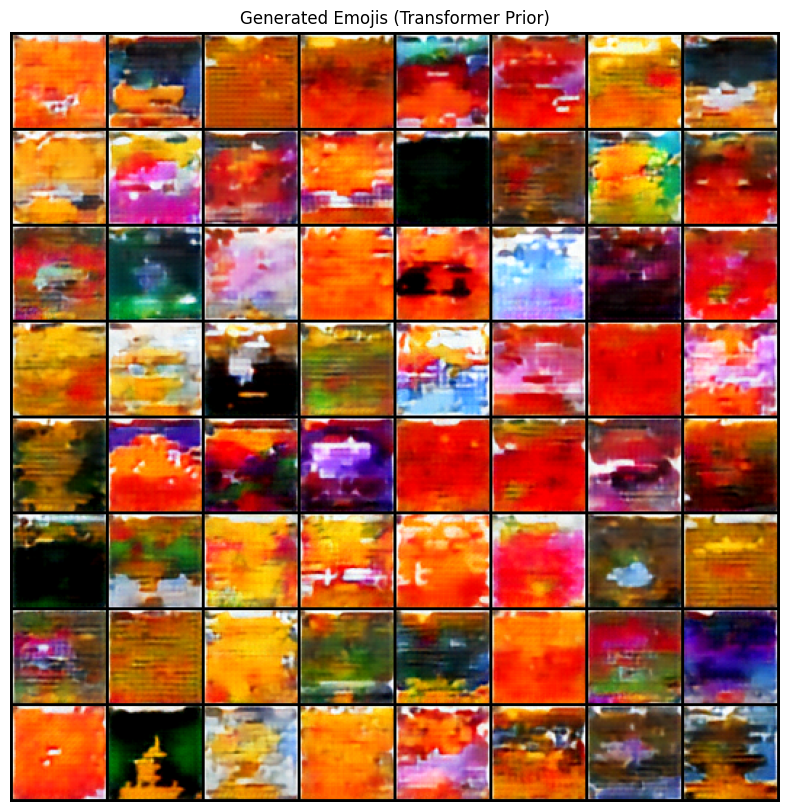

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Visualize the generated images
# Assuming generated_images_transformer is available and num_samples_generate_transformer is defined

grid = vutils.make_grid(generated_images_transformer.cpu(), nrow=int(np.sqrt(generated_images_transformer.size(0))))
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.title("Generated Emojis (Transformer Prior)")
plt.axis('off')
plt.show()

### Finish task

### Subtask:
Summarize the process and findings of training and sampling from the Transformer prior.

**Reasoning**:
Provide a summary of the steps taken to train and sample from the Transformer, and comment on the quality of the generated samples based on the visualization.